Figure from `analysis_notebooks/R68_integral_yield_analysis.ipynb`.

In [1]:
#Import libraries & data

exec(open("../analysis_notebooks/nb_setup.py").read())#Is there a better way to do this?

from IPython.core.display import display, HTML
from matplotlib.pyplot import *
from tqdm.notebook import tqdm
from scipy.optimize import fsolve
from scipy.special import erf
from scipy.interpolate import CubicSpline
import pickle
import sys
sys.path.append('../python')
import R68_yield as Yield
import R68_spec_tools as spec
import R68_plot_tools as pt
display(HTML("<style>.container { width:100% !important; }</style>"))

#Set up notebook and load some R68 constants (V, eps, etc.)
from constants import *

#Load the data
import R68_load as r68

meas=r68.load_measured(keVmax=10)
g4=r68.load_G4(load_frac=1)
cap=r68.load_simcap(file='../analysis_notebooks/data/v3_400k.pkl',
                    rcapture=0.218, load_frac=1)

../mplstyles
3.3.4
/mnt/d/git/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


Loading Measured Data...
PuBe events:  (829944,)
Bkg events:  (222484,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
0.1  min
Loading ERs...
0.0  min
Loading (n,gamma) Data...
382155


In [2]:
#Function Definitions

def extract_Y_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins=None):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,
                                 doEffsyst=False, doBurstLeaksyst=False,
                                 output='reco-rate')
    
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    Ebin_ctr_rev=Ebin_ctr[::-1]

    rev_csum_meas=np.cumsum(R_meas[::-1])

    R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
    rev_csum_er=np.cumsum(R_sim_er[::-1])

    w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
    w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))
        
    E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
    w_nrng=np.concatenate((w_nr,w_ng))

    E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
    w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
    rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

    diff=rev_csum_meas-rev_csum_er
    E_nrs=[]
    error=[]
    for entry in diff:
        if np.isfinite(entry):
            args=np.argwhere(rev_csum_nrng>=entry)
            if len(args)==0:
                E_nrs.append(-99)
            else:
                E_nr_this=E_nrng_rev_srt[args[0][0]]
                error.append(rev_csum_nrng[args[0][0]]-entry)
                if len(E_nrs)>0:
                    E_nrs.append(min(E_nr_this,E_nrs[-1]))
                else:
                    E_nrs.append(E_nr_this)
        else:
            E_nrs.append(-999)
            error.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V
    error=np.array(error)
    
    return (E_nrs,Ys,error)

#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins

def extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, nIt=2, F=0, Ebins=None, seed=None):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #Initial yield, with no resolution effects
    E_nrs,Ys,errors=extract_Y_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins)
    
    iIt=0
    while iIt<nIt:
        iIt+=1
            
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        #Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
        
        Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])

        Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
        Y=Yield.Yield('User',[Y_fit])
        
        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        #Use this correspondence to map back to NR
        #But need to condition it outside of the spline region.
        #Just extrapolate with linear from each end
        xx=NRtoER(E_nrs[cFit],Y,V,eps)
        yy=E_nrs[cFit]
        #ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
        ERtoNR_fCS=lambda E: np.interp(E,xx,yy)
        pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
        pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
        ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

        E_er_sm=spec.getSmeared(E_er,seed=seed,F=F)
        E_er_sm[E_er_sm<0]=0

        E_nr_sm=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=seed,F=F))
        E_nr_sm[E_nr_sm<0]=0

        E_ng_sm=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=seed,F=F))
        E_ng_sm[E_ng_sm<0]=0
        
        E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)
        
    return (E_nrs,Ys,errors)

def Y_conditioned(E, Y_fCS, Emin, Ymin, Emax, Ymax):
    y=Y_fCS(E)
    y[E>=Emax]=Ymax
    y[E<=Emin]=Ymin
    return y

def Y_conditioned_test(E, Y_fCS, E_nrs_fit, Ys_fit):
    y=Y_fCS(E)
    
    ylow=np.poly1d(np.polyfit(E_nrs_fit[:2],Ys_fit[:2], 1))
    y[E<=E_nrs_fit[0]]=ylow(E[E<=E_nrs_fit[0]])
    #y[E<=E_nrs_fit[0]]=Ys_fit[0]
    
    yhi=np.poly1d(np.polyfit(E_nrs_fit[-2:],Ys_fit[-2:], 1))
    y[E>=E_nrs_fit[-1]]=yhi(E[E>=E_nrs_fit[-1]])
    #y[E>=E_nrs_fit[-1]]=Ys_fit[-1]
    
    y[y<0]=0
    return y

def ERtoNR(ER,Y,V,eps):
    if isinstance(Y,(float,int)):
        return ER*(1+V/eps)/(1+Y*V/eps)    
    else:
        func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
        NR_guess = ER
        return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    if isinstance(Y,(float,int)):
        return NR*(1+Y*V/eps)/(1+V/eps)
    else:
        return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

def Nint(Es,Emin,Emax):
    return np.sum((Es>=Emin)&(Es<Emax))

def extract_Y(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, E_nr_step=1):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global Ebins,R_meas,tlive_er,tlive_nr,tlive_ng, V, eps
    
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    E_nrs=[]
    E_nr_test=E_nr_max
    for i in tqdm(range(len(Ebin_ctr))[::-1]):
        if np.isfinite(R_meas[i]):
            #Is there a more efficienct way to do this? Yep
            # Am I going to spend time working it out? Nope
            while True:
                R_meas_this=np.sum(R_meas[(Ebin_ctr>=Ebin_ctr[i])&(Ebin_ctr<E_er_max)])
                R_sim_er=fer*Nint(E_er,Ebin_ctr[i],E_er_max)/tlive_er
                R_sim_nr=fnr*Nint(E_nr,E_nr_test,E_nr_max)/tlive_nr
                R_sim_ng=fng*Nint(E_ng,E_nr_test,E_nr_max)/tlive_ng
                R_sim_this=R_sim_er+R_sim_nr+R_sim_ng

                if (R_sim_this>=R_meas_this) or (E_nr_test<0):
                    break
                E_nr_test-=E_nr_step

            E_nrs.append(E_nr_test)
        else:
            E_nrs.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    
    #E_ee=E_nr*(1+Y*V/eps)/(1+V/eps)
    #=> Y=((E_ee/E_nr)*(1+V/eps)-1)*eps/V
    Ys=((Ebin_ctr/E_nrs)*(1+V/eps)-1)*eps/V
    
    return (E_nrs,Ys)

def Y_fit(E):
    y=Y_fCS(E)
    y[E>E_nrs[-1]]=Ys[-1]
    y[E<0]=0
    return y

def extract_Y_wSmear(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, E_nr_step=1,nIt=2):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global Ebins,R_meas,tlive_er,tlive_nr,tlive_ng, V, eps
    
    
    #Initial yield, with no resolution effects
    E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, E_nr_step)
    
    iIt=0
    while iIt<nIt:
        iIt+=1
        
        cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

        Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
        Y=Yield.Yield('User',[Y_fit])
        #E_nr_sm=ERtoNR(spec.getSmeared(NRtoER(E_nr,Y,V,eps)),Y,V,eps)#Overflow and slow
        #E_ng_sm1=ERtoNR(spec.getSmeared(NRtoER(E_ng,Y,V,eps)),Y,V,eps)
        
        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        #Use this correspondence to map back to NR
        cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        ERtoNR_fCS=CubicSpline(NRtoER(E_nrs[cFit],Y,V,eps),E_nrs[cFit])

        E_er_sm=spec.getSmeared(E_er)
        E_er_sm[E_er_sm<0]=0
        E_nr_sm=ERtoNR_fCS(spec.getSmeared(E_nr_eVee))
        E_nr_sm[E_nr_sm<0]=0
        E_ng_sm=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))
        E_ng_sm[E_ng_sm<0]=0
        
        E_nrs,Ys=extract_Y(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, E_nr_step)
        
    return (E_nrs,Ys)

def Y_conditioned(E, Y_fCS, Emin, Ymin, Emax, Ymax):
    y=Y_fCS(E)
    y[E>=Emax]=Ymax
    y[E<=Emin]=Ymin
    return y

#TODO: use this same function every time we do this
def getYfitCond(E_nrs,Ys):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    return Yield.Yield('User',[Y_fit])

#Find the full enevelope of yield curves
#Includes first and last point of each curve and the min and max Y at each Enr

def getEYenvelope(lE_nrs_sample,lYs_sample,eVeeMin=50):
    Yenv_left=[]
    Yenv_right=[]
    Enr_env_left=[]
    Enr_env_right=[]

    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Yenv_left.append(Ys[cFit&(Ebin_ctr>eVeeMin)][0])
        Enr_env_left.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][0])
        Yenv_right.append(Ys[cFit&(Ebin_ctr>eVeeMin)][-1])
        Enr_env_right.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][-1])
        
    Enr_env_right=np.array(Enr_env_right)
    Yenv_right=np.array(Yenv_right)
    Enr_env_left=np.array(Enr_env_left)
    Yenv_left=np.array(Yenv_left)

    Enr_env_top=np.linspace(Enr_env_left[np.argmax(Yenv_left)],Enr_env_right[np.argmax(Yenv_right)],1000)
    Ytestmax=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_top)
        cgoodval=(Enr_env_top>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=-99
        Ytestmax.append(Ytesti)
    Yenv_top=np.max(np.array(Ytestmax),axis=0)        

    Enr_env_bottom=np.linspace(Enr_env_left[np.argmin(Yenv_left)],Enr_env_right[np.argmin(Yenv_right)],1000)
    Ytestmin=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_bottom)
        cgoodval=(Enr_env_bottom>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=99
        Ytestmin.append(Ytesti)
    Yenv_bottom=np.min(np.array(Ytestmin),axis=0)        

    #Need to sort the points so that they form a closed polygon
    #Go clockwise from top left

    Enr_env=np.concatenate( (Enr_env_top, Enr_env_right[np.argsort(Enr_env_right)], Enr_env_bottom[::-1], Enr_env_left[np.argsort(Enr_env_left)][::-1]) )
    Yenv=np.concatenate((Yenv_top, Yenv_right[np.argsort(Enr_env_right)], Yenv_bottom[::-1], Yenv_left[np.argsort(Enr_env_left)][::-1]))

    return (Enr_env, Yenv)

#Find the full range of rates for each component for plotting
def getERminmax(lE_nrs_sample,lYs_sample,lfer_sample,lfnr_sample,lfng_sample,dosmear=True,FanoER=0.1161,FanoNR=0.1161):
    R_er_test=[]
    R_nr_test=[]
    R_ng_test=[]
    
    for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs_sample,lYs_sample,lfer_sample,lfnr_sample,lfng_sample):
        Y=getYfitCond(E_nrs,Ys)
        
        if dosmear:
            E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
            #E_er_sm[E_er_sm<0]=0
            E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
            #E_nr_eVee_sm[E_nr_eVee_sm<0]=0
            E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
            #E_ng_eVee_sm[E_ng_eVee_sm<0]=0
        else:
            E_er_sm=E_er
            E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
            E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


        C_er,_=np.histogram(E_er_sm,bins=Ebins)
        R_er=fer*C_er/tlive_er

        C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
        R_nr=fnr*C_nr/tlive_nr

        C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
        R_ng=fng*C_ng/tlive_ng

        R_er_test.append(R_er)
        R_nr_test.append(R_nr)
        R_ng_test.append(R_ng)
    
    R_er_test=np.array(R_er_test)
    R_nr_test=np.array(R_nr_test)
    R_ng_test=np.array(R_ng_test)
    
    R_total_test=R_er_test+R_nr_test+R_ng_test

    Renvelopes={'eVee':Ebin_ctr,
                'ER':{'max':np.max(R_er_test,axis=0),'min':np.min(R_er_test,axis=0)},
                'NR':{'max':np.max(R_nr_test,axis=0),'min':np.min(R_nr_test,axis=0)},
                'NG':{'max':np.max(R_ng_test,axis=0),'min':np.min(R_ng_test,axis=0)},
                'Total':{'max':np.max(R_total_test,axis=0),'min':np.min(R_total_test,axis=0)},
               }
    return Renvelopes

def extract_Y_v3(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins=None):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,
                                 doEffsyst=False, doBurstLeaksyst=False,
                                 output='reco-rate')
    
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    Ebin_ctr_rev=Ebin_ctr[::-1]

    rev_csum_meas=np.cumsum(R_meas[::-1])

    R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
    rev_csum_er=np.cumsum(R_sim_er[::-1])

    w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
    w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))
        
    E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
    w_nrng=np.concatenate((w_nr,w_ng))

    E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
    w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
    rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

    diff=rev_csum_meas-rev_csum_er
    E_nrs=[]
    error=[]
    for entry in diff:
        if np.isfinite(entry):
            args=np.argwhere(rev_csum_nrng>=entry)
            if len(args)==0:
                E_nrs.append(-99)
            else:
                E_nr_this=E_nrng_rev_srt[args[0][0]]
                error.append(rev_csum_nrng[args[0][0]]-entry)
                if len(E_nrs)>0:
                    E_nrs.append(min(E_nr_this,E_nrs[-1]))
                else:
                    E_nrs.append(E_nr_this)
        else:
            E_nrs.append(-999)
            error.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V
    error=np.array(error)
    
    return (E_nrs,Ys,error)

def extract_Y_wSmear_v3(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, nIt=2, FanoER=0.1161, FanoNR=0.1161, Ebins=None, seed=None):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #Initial yield, with no resolution effects
    E_nrs,Ys,errors=extract_Y_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins)
    
    iIt=0
    while iIt<nIt:
        iIt+=1
        
        Y=getYfitCond(E_nrs,Ys)

        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        ERtoNR_fit=getEEtoNRfitCond(E_nrs,Y)
        
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
        E_nr_sm=ERtoNR_fit(spec.getSmeared(E_nr_eVee,seed=seed,F=FanoNR))
        E_ng_sm=ERtoNR_fit(spec.getSmeared(E_ng_eVee,seed=seed,F=FanoNR))
        E_nrs,Ys,errors=extract_Y_v3(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)
        
    return (E_nrs,Ys,errors)

#Find the full range of rates for each component for plotting
def getERminmax_v3(scanData,cut,dosmear=True,seed=None,nAvg=1):
    R_er_test=[]
    R_nr_test=[]
    R_ng_test=[]
    
    for i in range(len(scanData['lE_nrs'][cut])):
        E_nrs=scanData['lE_nrs'][cut][i]
        Ys=scanData['lYs'][cut][i]
        fer=scanData['lfer'][cut][i]
        fnr=scanData['lfnr'][cut][i]
        fng=scanData['lfng'][cut][i]
        FanoER=scanData['lFanoER'][cut][i]
        FanoNR=scanData['lFanoNR'][cut][i]
        
        Y=getYfitCond(E_nrs,Ys)
        
        
        R_er_avg=[]
        R_nr_avg=[]
        R_ng_avg=[]
        for iteration in range(nAvg):
            if dosmear:
                E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
                E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
                E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
            else:
                E_er_sm=E_er
                E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
                E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


            C_er,_=np.histogram(E_er_sm,bins=Ebins)
            R_er=fer*C_er/tlive_er

            C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
            R_nr=fnr*C_nr/tlive_nr

            C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
            R_ng=fng*C_ng/tlive_ng
            
            R_er_avg.append(R_er)
            R_nr_avg.append(R_nr)
            R_ng_avg.append(R_ng)

        R_er_test.append(np.mean(np.array(R_er_avg),axis=0))
        R_nr_test.append(np.mean(np.array(R_nr_avg),axis=0))
        R_ng_test.append(np.mean(np.array(R_ng_avg),axis=0))
    
    R_er_test=np.array(R_er_test)
    R_nr_test=np.array(R_nr_test)
    R_ng_test=np.array(R_ng_test)
    
    R_total_test=R_er_test+R_nr_test+R_ng_test

    Renvelopes={'eVee':Ebin_ctr,
                'ER':{'max':np.max(R_er_test,axis=0),'min':np.min(R_er_test,axis=0)},
                'NR':{'max':np.max(R_nr_test,axis=0),'min':np.min(R_nr_test,axis=0)},
                'NG':{'max':np.max(R_ng_test,axis=0),'min':np.min(R_ng_test,axis=0)},
                'Total':{'max':np.max(R_total_test,axis=0),'min':np.min(R_total_test,axis=0)},
               }
    return Renvelopes

def Y_conditioned(E, Y_fCS, Emin, Ymin, Emax, Ymax):
    y=Y_fCS(E)
    y[E>=Emax]=Ymax
    y[E<=Emin]=Ymin
    return y

def getYfitCond(E_nrs,Ys):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    return Yield.Yield('User',[Y_fit])

#Fitted function to map from eVee back to eVnr
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
def getEEtoNRfitCond(E_nrs,Y):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    
    xx=NRtoER(E_nrs[cFit],Y,V,eps)
    yy=E_nrs[cFit]
    
    ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
    pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))#Should maintain const Y at low end
    pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
    EEtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

    return EEtoNR_fcombo

#v4: Remove R_meas calculation and use global value.
#Assumes R_meas matches Ebins.
def extract_Y_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins=None):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps, R_meas
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,
    #                             doEffsyst=False, doBurstLeaksyst=False,
    #                             output='reco-rate')
    
    E_er_max=Ebins[-1]
    E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

    Ebin_ctr_rev=Ebin_ctr[::-1]

    rev_csum_meas=np.cumsum(R_meas[::-1])

    R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
    rev_csum_er=np.cumsum(R_sim_er[::-1])

    w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
    w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))
        
    E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
    w_nrng=np.concatenate((w_nr,w_ng))

    E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
    w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
    rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

    diff=rev_csum_meas-rev_csum_er
    E_nrs=[]
    error=[]
    for entry in diff:
        if np.isfinite(entry):
            args=np.argwhere(rev_csum_nrng>=entry)
            if len(args)==0:
                E_nrs.append(-99)
            else:
                E_nr_this=E_nrng_rev_srt[args[0][0]]
                error.append(rev_csum_nrng[args[0][0]]-entry)
                if len(E_nrs)>0:
                    E_nrs.append(min(E_nr_this,E_nrs[-1]))
                else:
                    E_nrs.append(E_nr_this)
        else:
            E_nrs.append(-999)
            error.append(-999)
    E_nrs=np.array(E_nrs[::-1])
    Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V
    error=np.array(error)
    
    return (E_nrs,Ys,error)

def extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max,
                        nItMax=2, fit_frac_all_goal=0.8, fit_frac_low_goal=1,
                        FanoER=0.1161, FanoNR=0.1161, Ebins=None, seed=None):
    #Assumed global variables:
    #Ebins: eVee bins
    #R_meas: Measured, bkg-subtracted, efficiency-corrected rate
    #tlive_er(nr,ng): livetime of ER(NR,NG) hits
    global tlive_er,tlive_nr,tlive_ng, V, eps
    
    if Ebins is None:
        Ebins=np.linspace(0,2e3,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
    
    #Initial yield, with no resolution effects
    E_nrs,Ys,errors=extract_Y_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max, Ebins)
    
    iIt=0
    while iIt<nItMax:
        
        Y=getYfitCond_v4(E_nrs,Ys)

        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        ERtoNR_fit=getEEtoNRfitCond_v4(E_nrs,Y)
        
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
        E_nr_eVee_sm=spec.getSmeared(E_nr_eVee,seed=seed,F=FanoNR)
        E_ng_eVee_sm=spec.getSmeared(E_ng_eVee,seed=seed,F=FanoNR)

        #Check if the currently smeared version agrees with the measurement
        C_er,_=np.histogram(E_er_sm,bins=Ebins)
        R_er=fer*C_er/tlive_er

        C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
        R_nr=fnr*C_nr/tlive_nr

        C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
        R_ng=fng*C_ng/tlive_ng

        R_tot=R_er+R_nr+R_ng
        
        #Some goodness of fit condition
        #Hard to get this right because we want the whole thing to fit well, but are 
        #  especially concerned about the lowest few bins which tend to go astray
        R_max=R_meas[Ebin_ctr>50]+1*dR_meas[0][Ebin_ctr>50]
        R_min=R_meas[Ebin_ctr>50]-1*dR_meas[1][Ebin_ctr>50]
        #fracion of bins within error bars
        fit_frac_all=np.sum((R_tot[Ebin_ctr>50]<=R_max)&(R_tot[Ebin_ctr>50]>=R_min))/np.sum(Ebin_ctr>50)
        #Fraction of lowest 10 bins within error bars
        fit_frac_low=np.sum((R_tot[Ebin_ctr>50][:10]<=R_max[:10])&(R_tot[Ebin_ctr>50][:10]>=R_min[:10]))/10
        
        if (fit_frac_all>=fit_frac_all_goal) and (fit_frac_low>=fit_frac_low_goal):
            break
            
        #Continue to the next iteration
        iIt+=1
        E_nr_sm=ERtoNR_fit(E_nr_eVee_sm)
        E_ng_sm=ERtoNR_fit(E_ng_eVee_sm)
        
        E_nrs,Ys,errors=extract_Y_v4(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)
        
    return (E_nrs,Ys,errors,iIt)

def Y_conditioned_v4(E, Y_fit_func, E_nrs_fit, Ys_fit):
    y=Y_fit_func(E)
    
    ylow=np.poly1d(np.polyfit(E_nrs_fit[:2],Ys_fit[:2], 1))
    y[E<=E_nrs_fit[0]]=ylow(E[E<=E_nrs_fit[0]])
    
    yhi=np.poly1d(np.polyfit(E_nrs_fit[-2:],Ys_fit[-2:], 1))
    y[E>=E_nrs_fit[-1]]=yhi(E[E>=E_nrs_fit[-1]])

    y[y<0]=0
    return y

def getYfitCond_v4(E_nrs,Ys):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fit_func=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    Y_fit = lambda E: Y_conditioned_v4(E,Y_fit_func,E_nrs[cFit],Ys[cFit])
    return Yield.Yield('User',[Y_fit])

#Fitted function to map from eVee back to eVnr
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
def getEEtoNRfitCond_v4(E_nrs,Y):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    
    xx=NRtoER(E_nrs[cFit],Y,V,eps)
    yy=E_nrs[cFit]
    
    ERtoNR_fit_func=lambda E: np.interp(E,xx,yy)
    pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))#Should maintain const Y at low end
    pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
    EEtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fit_func(E) + (E>xx[-1])*pf_hi(E)

    return EEtoNR_fcombo

#Find the full range of rates for each component for plotting
#v4: Updated getYfitCond version
def getERminmax_v4(scanData,cut,dosmear=True,seed=None,nAvg=1):
    R_er_test=[]
    R_nr_test=[]
    R_ng_test=[]
    
    for i in range(len(scanData['lE_nrs'][cut])):
        E_nrs=scanData['lE_nrs'][cut][i]
        Ys=scanData['lYs'][cut][i]
        fer=scanData['lfer'][cut][i]
        fnr=scanData['lfnr'][cut][i]
        fng=scanData['lfng'][cut][i]
        FanoER=scanData['lFanoER'][cut][i]
        FanoNR=scanData['lFanoNR'][cut][i]
        
        Y=getYfitCond_v4(E_nrs,Ys)
        
        
        R_er_avg=[]
        R_nr_avg=[]
        R_ng_avg=[]
        for iteration in range(nAvg):
            if dosmear:
                E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
                E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
                E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
            else:
                E_er_sm=E_er
                E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
                E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


            C_er,_=np.histogram(E_er_sm,bins=Ebins)
            R_er=fer*C_er/tlive_er

            C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
            R_nr=fnr*C_nr/tlive_nr

            C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
            R_ng=fng*C_ng/tlive_ng
            
            R_er_avg.append(R_er)
            R_nr_avg.append(R_nr)
            R_ng_avg.append(R_ng)

        R_er_test.append(np.mean(np.array(R_er_avg),axis=0))
        R_nr_test.append(np.mean(np.array(R_nr_avg),axis=0))
        R_ng_test.append(np.mean(np.array(R_ng_avg),axis=0))
    
    R_er_test=np.array(R_er_test)
    R_nr_test=np.array(R_nr_test)
    R_ng_test=np.array(R_ng_test)
    
    R_total_test=R_er_test+R_nr_test+R_ng_test

    Renvelopes={'eVee':Ebin_ctr,
                'ER':{'max':np.max(R_er_test,axis=0),'min':np.min(R_er_test,axis=0)},
                'NR':{'max':np.max(R_nr_test,axis=0),'min':np.min(R_nr_test,axis=0)},
                'NG':{'max':np.max(R_ng_test,axis=0),'min':np.min(R_ng_test,axis=0)},
                'Total':{'max':np.max(R_total_test,axis=0),'min':np.min(R_total_test,axis=0)},
               }
    return Renvelopes

#Find the full enevelope of yield curves
#Includes first and last point of each curve and the min and max Y at each Enr
def getEYenvelope_v4(lE_nrs_sample,lYs_sample,eVeeMin=50):
    Yenv_left=[]
    Yenv_right=[]
    Enr_env_left=[]
    Enr_env_right=[]

    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Yenv_left.append(Ys[cFit&(Ebin_ctr>eVeeMin)][0])
        Enr_env_left.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][0])
        Yenv_right.append(Ys[cFit&(Ebin_ctr>eVeeMin)][-1])
        Enr_env_right.append(E_nrs[cFit&(Ebin_ctr>eVeeMin)][-1])
        
    Enr_env_right=np.array(Enr_env_right)
    Yenv_right=np.array(Yenv_right)
    Enr_env_left=np.array(Enr_env_left)
    Yenv_left=np.array(Yenv_left)

    Enr_env_top=np.linspace(Enr_env_left[np.argmax(Yenv_left)],Enr_env_right[np.argmax(Yenv_right)],1000)
    Ytestmax=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond_v4(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_top)
        cgoodval=(Enr_env_top>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=-99
        Ytestmax.append(Ytesti)
    Yenv_top=np.max(np.array(Ytestmax),axis=0)        

    Enr_env_bottom=np.linspace(Enr_env_left[np.argmin(Yenv_left)],Enr_env_right[np.argmin(Yenv_right)],1000)
    Ytestmin=[]
    for E_nrs,Ys in zip(lE_nrs_sample,lYs_sample):
        cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
        Y=getYfitCond_v4(E_nrs,Ys)
        Ytesti=Y.calc(Enr_env_bottom)
        cgoodval=(Enr_env_bottom>=np.min(E_nrs[Ebin_ctr>eVeeMin]))
        Ytesti[~cgoodval]=99
        Ytestmin.append(Ytesti)
    Yenv_bottom=np.min(np.array(Ytestmin),axis=0)        

    #Need to sort the points so that they form a closed polygon
    #Go clockwise from top left

    Enr_env=np.concatenate( (Enr_env_top, Enr_env_right[np.argsort(Enr_env_right)], Enr_env_bottom[::-1], Enr_env_left[np.argsort(Enr_env_left)][::-1]) )
    Yenv=np.concatenate((Yenv_top, Yenv_right[np.argsort(Enr_env_right)], Yenv_bottom[::-1], Yenv_left[np.argsort(Enr_env_left)][::-1]))

    return (Enr_env, Yenv)

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)

Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

#uncertainty is (high,low)
R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,\
                             doEffsyst=True, doBurstLeaksyst=True,\
                             output='reco-rate')

../python/R68_spec_tools.py:55: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:60: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/TE_Bkg


In [4]:
#Illustration of method

Elim_er=[255.0,505.0,1005.0,1505.0,1995.0]
Elim_nr=[806.3832567888599, 1967.2490338155576, 4045.3075738134753, 5739.940139258986, 7281.31517699986]

for Elim in Elim_er[:-1]:
    cut=(Ebin_ctr>=Elim)&(Ebin_ctr<=Elim_er[-1])

In [5]:
c,b=np.histogram(np.sum(g4['ER']['E'],axis=1),bins=Ebins)
bctr=(b[:-1]+b[1:])/2

for Elim in Elim_er[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_er[-1])

Ebnr=np.linspace(0,7.3e3,200)
c,b=np.histogram(np.sum(g4['NR']['E'],axis=1),bins=Ebnr)
bctr=(b[:-1]+b[1:])/2

for Elim in Elim_nr[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_nr[-1])

c,b=np.histogram(np.sum(cap['dE'],axis=1),bins=Ebnr)
bctr=(b[:-1]+b[1:])/2

for Elim in Elim_nr[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_nr[-1])

In [6]:
#For this analysis, we'll just use the total Edep of each event and apply yield to that.
#How big of an assumption is this?
E_er=np.sum(g4['ER']['E'],axis=1)
E_nr=np.sum(g4['NR']['E'],axis=1)
E_ng=np.sum(cap['dE'],axis=1)

In [7]:
Emax_frac_er=np.max(g4['ER']['E'],axis=1)/np.sum(g4['ER']['E'],axis=1)
Emax_frac_nr=np.max(g4['NR']['E'],axis=1)/np.sum(g4['NR']['E'],axis=1)
Emax_frac_ng=np.max(cap['dE'],axis=1)/np.sum(cap['dE'],axis=1)

In [8]:
#Trim events that won't figure into the analysis range
E_er=E_er[(E_er>0) & (E_er<10e3)]
E_nr=E_nr[(E_nr>0) & (E_nr<1000e3)]

In [9]:
#Spectra with default livetimes and standard yield, Fano

#Y=Yield.Yield('Lind',[0.146])
Y=Yield.Yield('Chav',[0.146,1e3/0.247])

N_er,_=np.histogram(E_er,bins=Ebins)
N_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
N_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)

R_er=N_er/g4['ER']['tlive']
R_nr=N_nr/g4['NR']['tlive']
R_ng=N_ng/cap['tlive']

In [10]:
#Need to set some NR max I think. 
#Not sure how to choose this because there's NRs up to 1 MeV
#Do we need a fixed (Er,Y) to work from?

Y=Yield.Yield('Lind',[0.146])
E_nr_max=ERtoNR(Ebin_ctr[-1],Y,V,eps)[0]

fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y,V,eps)[0],E_nr_max)/g4['NR']['tlive'])
fng=0

E_nrs=[]
E_nr_step=1
E_nr_test=E_nr_max
for i in tqdm(range(len(Ebin_ctr))[::-1]):
    if np.isfinite(R_meas[i]):
        while True:
            R_meas_this=np.sum(R_meas[(Ebin_ctr>Ebin_ctr[i])&(Ebin_ctr<2e3)])
            R_sim_this=fg4*(Nint(E_er,Ebin_ctr[i],2e3)/g4['ER']['tlive'] + Nint(E_nr,E_nr_test,E_nr_max)/g4['NR']['tlive']) + fng*Nint(E_ng,E_nr_test,E_nr_max)/cap['tlive']

            if (R_meas_this<R_sim_this) or (E_nr_test<0):
                break
            E_nr_test-=E_nr_step
            
        E_nrs.append(E_nr_test)
    else:
        E_nrs.append(np.inf)
E_nrs=np.array(E_nrs[::-1])

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
Ys=((Ebin_ctr/E_nrs)*(1+V/eps)-1)*eps/V

cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit])

Y=Yield.Yield('Chav',[0.146,1e3/0.247])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1281: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [12]:
C_er,_=np.histogram(E_er,bins=Ebins)
R_er=fg4*C_er/g4['ER']['tlive']

Y=Yield.Yield('User',[Y_fCS])
C_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
R_nr=fg4*C_nr/g4['NR']['tlive']
C_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)
R_ng=fng*C_ng/cap['tlive']

In [13]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

In [14]:
lY_max=np.linspace(0.1,0.6,6)
lfer=[]
lfnr=[]
lE_nrs=[]
lYs=[]
for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV
    fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
    lfer.append(fg4)
    lfnr.append(fg4)
    E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=0, Y_max=Y_max, E_nr_step=1)
    lE_nrs.append(E_nrs)
    lYs.append(Ys)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
for E_nrs,Ys in zip(lE_nrs,lYs):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

for E_nrs,Ys,fer,fnr in zip(lE_nrs,lYs,lfer,lfnr):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    C_er,_=np.histogram(E_er,bins=Ebins)
    R_er=fer*C_er/tlive_er
    Y=Yield.Yield('User',[Y_fCS])
    C_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

In [16]:
bins=np.linspace(-100,2500,100)
#Looks like that's doing the right thing. Maybe need to truncate at 0
ERsmeared=spec.getSmeared(NRtoER(E_ng,0.2,V,eps))
ERsmeared[ERsmeared<0]=0

In [17]:
Y_max=0.25
#Normalize so that ER+NR matches data near 2 keV
fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])

E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)
cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
Y=Yield.Yield('User',[Y_fit])
E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
ERtoNR_fCS=CubicSpline(NRtoER(E_nrs[cFit],Y,V,eps),E_nrs[cFit])

E_nr_sm=ERtoNR_fCS(spec.getSmeared(E_nr_eVee))
E_ng_sm=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))
E_ng_sm2=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))

Ebnr=np.linspace(0,3e3,200)

In [19]:
E_nrs_0=E_nrs
Ys_0=Ys
E_nrs,Ys=extract_Y(E_er, E_nr_sm, E_ng_sm, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)
cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

In [21]:
Y_max=0.25
#Normalize so that ER+NR matches data near 2 keV
fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])

E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)

cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[E_nrs>0][0],0,E_nrs[-1],Ys[-1])

E_nrs,Ys=extract_Y_wSmear(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, nIt=1, E_nr_step=1)

cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[E_nrs>0][0],0,E_nrs[-1],Ys[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
lY_max=[0.3]
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV
    fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
    lfer.append(fg4)
    lfnr.append(fg4)
    lfng.append(1)
    E_nrs,Ys=extract_Y_wSmear(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max,
                              nIt=1, E_nr_step=1)
    lE_nrs.append(E_nrs)
    lYs.append(Ys)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [23]:
for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs,lYs,lfer,lfnr,lfng):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    #Smear
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
    Y=Yield.Yield('User',[Y_fit])
    
    E_er_sm=spec.getSmeared(E_er)
    E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps))
    E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps))
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

In [24]:
Y_max=0.3

R0_meas=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)])
R0_er=Nint(E_er,1.9e3,2e3)/g4['ER']['tlive']
R0_nr=Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

fer=0
fnr=(R0_meas)/R0_nr
fng=0

E_er_max=2e3
E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

Ebin_ctr_rev=Ebin_ctr[::-1]

rev_csum_meas=np.cumsum(R_meas[::-1])

R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
rev_csum_er=np.cumsum(R_sim_er[::-1])

w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))

E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
w_nrng=np.concatenate((w_nr,w_ng))

E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

diff=rev_csum_meas-rev_csum_er
E_nrs=[]
error=[]
for entry in diff:
    if np.isfinite(entry):
        args=np.argwhere(rev_csum_nrng>=entry)
        if len(args)==0:
            E_nrs.append(-99)
        else:
            E_nr_this=E_nrng_rev_srt[args[0][0]]
            error.append(rev_csum_nrng[args[0][0]]-entry)
            if len(E_nrs)>0:
                E_nrs.append(min(E_nr_this,E_nrs[-1]))
            else:
                E_nrs.append(E_nr_this)
    else:
        E_nrs.append(-999)
        error.append(-999)
E_nrs=np.array(E_nrs[::-1])
Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V

In [25]:
cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

E_er_sm=E_er
E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)

C_er,_=np.histogram(E_er_sm,bins=Ebins)
R_er=fer*C_er/tlive_er
C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
R_nr=fnr*C_nr/tlive_nr
C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
R_ng=fng*C_ng/tlive_ng

In [26]:
E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm=spec.getSmeared(E_er,seed=None,F=F)
E_er_sm[E_er_sm<0]=0
E_nr_sm=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
E_ng_sm=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))

In [27]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm2=spec.getSmeared(E_er,seed=None,F=F)
E_nr_sm2=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
E_ng_sm2=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))

../python/R68_spec_tools.py:69: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(dTE_Bkg/TE_Bkg)**2 )


In [28]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm2, E_nr_sm2, E_ng_sm2, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm3=spec.getSmeared(E_er,seed=None,F=F)
E_nr_sm3=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
E_ng_sm3=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))

In [29]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

In [30]:
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

lY_max=np.linspace(0.2,0.3,5)
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
lerrors=[]

for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV

    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    fnr=6
    fer=(R0_meas-fnr*R0_nr)/R0_er
    fng=2#2.037

    lfer.append(fer)
    lfnr.append(fnr)
    lfng.append(fng)
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=1, Ebins=np.linspace(0,2e3,201), seed=None)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

  0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
dosmear=True
seed=None

#Add other measurements from lit
for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs,lYs,lfer,lfnr,lfng):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    
    #Smear
    Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
    Y=Yield.Yield('User',[Y_fit])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [32]:
lnIt=[0,1,2,5,10,15,20,30]
lY_max=[]
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
lerrors=[]

for nIt in tqdm(lnIt):

    Y_max=0.25
    
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']
    
    
    lY_max.append(Y_max)
    fnr=6
    fer=(R0_meas-fnr*R0_nr)/R0_er
    fng=4#2.037+0.41

    lfer.append(fer)
    lfnr.append(fnr)
    lfng.append(fng)
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=nIt, Ebins=np.linspace(0,2e3,201), seed=None)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

  0%|          | 0/8 [00:00<?, ?it/s]

In [33]:
dosmear=True
seed=None

#Add other measurements from lit

for E_nrs,Ys,fer,fnr,fng,nIt in zip(lE_nrs,lYs,lfer,lfnr,lfng,lnIt):
    
    cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    
    #Smear
    Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
    
    Y=Yield.Yield('User',[Y_fit])
    
    if nIt>0:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [34]:
E_nrs=lE_nrs[4]
Ys=lYs[4]

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])

#Smear
Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
Y=Yield.Yield('User',[Y_fit])

In [35]:
lY_max=np.concatenate((np.linspace(0.2,0.3,5),np.linspace(0.2,0.3,5)))
lfer=[]
lfnr=[]
lfng=np.concatenate(((2.037+0.408)*np.ones(5),(2.037-0.408)*np.ones(5)))
lE_nrs=[]
lYs=[]
lerrors=[]

for Y_max,fng in zip(tqdm(lY_max),lfng):
    #Normalize near 2keV
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    fer=(R0_meas)/(R0_er+R0_nr)
    fnr=fer

    lfer.append(fer)
    lfnr.append(fnr)
    
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=1, Ebins=np.linspace(0,2e3,201), seed=0)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
dosmear=True
seed=0

#Add other measurements from lit

N=len(lE_nrs)
for i in range(int(N/2)):    
    
    cFit1=(Ebin_ctr>50) &(lE_nrs[i]>0) & (np.isfinite(lE_nrs[i])) & (np.insert(np.diff(lE_nrs[i])>0,-1,True))
    E_nrs1=lE_nrs[i][cFit1]
    Ys1=lYs[i][cFit1]
    Y_fCS1=CubicSpline(E_nrs1,Ys1,extrapolate=True)
    
    cFit2=(Ebin_ctr>50) &(lE_nrs[i+int(N/2)]>0) & (np.isfinite(lE_nrs[i+int(N/2)])) & (np.insert(np.diff(lE_nrs[i+int(N/2)])>0,-1,True))
    E_nrs2=lE_nrs[i+int(N/2)][cFit2]
    Ys2=lYs[i+int(N/2)][cFit2]
    Y_fCS2=CubicSpline(E_nrs2,Ys2,extrapolate=True)
    
    #Smear
    
    Y_fit1 = lambda E: Y_conditioned(E,Y_fCS1,E_nrs1[0],Ys1[0],E_nrs1[-1],Ys1[-1])
    Y1=Yield.Yield('User',[Y_fit1])
    Y_fit2 = lambda E: Y_conditioned(E,Y_fCS2,E_nrs2[0],Ys2[0],E_nrs2[-1],Ys2[-1])
    Y2=Yield.Yield('User',[Y_fit2])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y1,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y1,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y1,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y1,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y1,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=lfer[i]*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=lfnr[i]*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=lfng[i]*C_ng/tlive_ng
    
    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [37]:
izr=pt.get_old_Y_data()
Y_izr_up=CubicSpline(izr['Enr'],izr['Y'],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_izr_up,izr['Enr'][0],(izr['Y'])[0],izr['Enr'][-1],(izr['Y'])[-1])
Y=Yield.Yield('User',[Y_fit])
xx=np.linspace(0,30e3,1000)

In [38]:
#Load data if possible. If not possible, save for future use.
save = False
try:
    with open( "data/cdf_results.p", "rb" ) as file:
        results = pickle.load( file )
    lY_max=results['lY_max']
    lfer=results['lfer']
    lfnr=results['lfnr']
    lfng=results['lfng']
    lE_nrs=results['lE_nrs']
    lYs=results['lYs']
    lerrors=results['lerrors']
except:
    save = True

In [39]:
#Let's scan through a bunch of scalings and then only retain those which are consistent with Izr

if save:
    lY_max=[]
    lfer=[]
    lfnr=[]
    lfng=[]
    lE_nrs=[]
    lYs=[]
    lerrors=[]
    for Y_max in tqdm(np.linspace(0.25,0.29,20)):
        for fnr in np.linspace(4,9,20):
            for fng in [0,2.037+0.408,2.037-0.408]:

                lY_max.append(Y_max)
                #Normalize near 2keV
                R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
                R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
                R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

                fer=(R0_meas-fnr*R0_nr)/R0_er

                lfer.append(fer)
                lfnr.append(fnr)
                lfng.append(fng)

                E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                          nIt=1, Ebins=np.linspace(0,2e3,201), seed=0, F=0.1161)
                #If binning is too small, will get some errors and things won't work.
                #Probably in bkg_sub, but not exactly sure
                lE_nrs.append(E_nrs)
                lYs.append(Ys)
                lerrors.append(errors)
    results={'lY_max':lY_max, 'lfer':lfer, 'lfnr':lfnr, 'lfng':lfng, 'lE_nrs':lE_nrs, 'lYs':lYs, 'lerrors':lerrors}
    with open( "data/cdf_results.p", "wb" ) as file:
        pickle.dump( results, file )

lY_max=np.array(lY_max)
lfer=np.array(lfer)
lfnr=np.array(lfnr)
lfng=np.array(lfng)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

In [40]:
#Find those which are consistent with Izr
cgood=[]
Y_1keV=[]
for E_nrs,Ys in zip(lE_nrs,lYs):
    Y=getYfitCond(E_nrs,Ys)
    
    cizr=izr['Enr']<E_nrs[-1]
    Y_1keV.append(Y.calc(1e3))
    
    cgood.append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
cgood=np.array(cgood)
Y_1keV=np.array(Y_1keV)

In [41]:
dosmear=True
seed=0
Fthis=0.1161

#Add other measurements from lit

for E_nrs,Ys,fer,fnr,fng,good in zip(lE_nrs,lYs,lfer,lfnr,lfng,cgood):
    if not good:
        continue
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    if fng==0:
        color='red'
    else:
        color='gray'
    
    #Smear
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    Y=Yield.Yield('User',[Y_fit])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=Fthis)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

In [42]:
#Pick mins and maxes at a given energy
#This isn't quite right, since envelope is not jsut from a single curve

ifng0=np.argwhere(cgood&(lfng==0))
ifng0_min=ifng0[np.argmin(Y_1keV[ifng0])][0]
ifng0_max=ifng0[np.argmax(Y_1keV[ifng0])][0]

ifng=np.argwhere(cgood&(lfng!=0))
ifng_min=ifng[np.argmin(Y_1keV[ifng])][0]
ifng_max=ifng[np.argmax(Y_1keV[ifng])][0]

In [43]:
dosmear=True
seed=0
Fthis=0.1161

#Add other measurements from lit

labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['red','gray']

for inds,label,color in zip([[ifng0_max,ifng0_min],[ifng_max,ifng_min]],labels,colors):
#for E_nrs,Ys,fer,fnr,fng,good in zip(lE_nrs,lYs,lfer,lfnr,lfng,cgood):

    i=inds[0]
    j=inds[1]
    
    cFit1=(Ebin_ctr>50) &(lE_nrs[i]>0) & (np.isfinite(lE_nrs[i])) & (np.insert(np.diff(lE_nrs[i])>0,-1,True))
    E_nrs1=lE_nrs[i][cFit1]
    Ys1=lYs[i][cFit1]
    Y_fCS1=CubicSpline(E_nrs1,Ys1,extrapolate=True)
    
    cFit2=(Ebin_ctr>50) &(lE_nrs[j]>0) & (np.isfinite(lE_nrs[j])) & (np.insert(np.diff(lE_nrs[j])>0,-1,True))
    E_nrs2=lE_nrs[j][cFit2]
    Ys2=lYs[j][cFit2]
    Y_fCS2=CubicSpline(E_nrs2,Ys2,extrapolate=True)
    
    #Smear
    Y_fit1 = lambda E: Y_conditioned(E,Y_fCS1,E_nrs1[0],Ys1[0],E_nrs1[-1],Ys1[-1])
    Y1=Yield.Yield('User',[Y_fit1])
    Y_fit2 = lambda E: Y_conditioned(E,Y_fCS2,E_nrs2[0],Ys2[0],E_nrs2[-1],Ys2[-1])
    Y2=Yield.Yield('User',[Y_fit2])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=Fthis)
        E_er_sm[E_er_sm<0]=0
        
        E_nr_eVee_sm1=spec.getSmeared(NRtoER(E_nr,Y1,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm1[E_nr_eVee_sm1<0]=0
        E_nr_eVee_sm2=spec.getSmeared(NRtoER(E_nr,Y2,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm2[E_nr_eVee_sm2<0]=0
        
        E_ng_eVee_sm1=spec.getSmeared(NRtoER(E_ng,Y1,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm1[E_ng_eVee_sm1<0]=0
        E_ng_eVee_sm2=spec.getSmeared(NRtoER(E_ng,Y2,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm2[E_ng_eVee_sm2<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm1=NRtoER(E_nr,Y1,V,eps)
        E_nr_eVee_sm2=NRtoER(E_nr,Y2,V,eps)
        E_ng_eVee_sm1=NRtoER(E_ng,Y1,V,eps)
        E_ng_eVee_sm2=NRtoER(E_ng,Y2,V,eps)
    
    C_er1,_=np.histogram(E_er_sm,bins=Ebins)
    R_er1=lfer[i]*C_er1/tlive_er
    C_er2,_=np.histogram(E_er_sm,bins=Ebins)
    R_er2=lfer[j]*C_er2/tlive_er
    
    C_nr1,_=np.histogram(E_nr_eVee_sm1,bins=Ebins)
    R_nr1=lfnr[i]*C_nr1/tlive_nr
    C_nr2,_=np.histogram(E_nr_eVee_sm2,bins=Ebins)
    R_nr2=lfnr[j]*C_nr2/tlive_nr
    
    C_ng1,_=np.histogram(E_ng_eVee_sm1,bins=Ebins)
    R_ng1=lfng[i]*C_ng1/tlive_ng
    C_ng2,_=np.histogram(E_ng_eVee_sm2,bins=Ebins)
    R_ng2=lfng[j]*C_ng2/tlive_ng

In [44]:
cut=cgood&(lfng!=0)
ERenvData=getERminmax(lE_nrs[cut],lYs[cut],lfer[cut],lfnr[cut],lfng[cut])

In [45]:
cut=cgood&(lfng!=0)
cut=cgood&(lfng==0)

#Add other measurements from lit
ERenvData=getERminmax(lE_nrs[cut],lYs[cut],lfer[cut],lfnr[cut],lfng[cut])

In [46]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins

#v3: Separate ER and NR Fanos. Also allow smeared energies to be negative

tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

In [47]:
save = False
try:
    with open( "data/intmeth_scan_v3.p", "rb" ) as file:
        scanData = pickle.load( file )
except:
    save = True

In [48]:
#Single data structure to hold all those arrays of stuff
if save:
    scanData={'lY_max':[], 'lfer':[], 'lfnr':[], 'lfng':[],
              'lE_nrs':[], 'lYs':[], 'lerrors':[], 'lFanoER':[],'lFanoNR':[]}

    for Y_max in tqdm(np.linspace(0.25,0.29,20)):
        for fnr in np.linspace(4,9,20):
            for fng in [0,2.037+0.408,2.037,2.037-0.408]:
                for FanoNR in [0.1161,1,2,5]:

                    scanData['lY_max'].append(Y_max)

                    #Normalize near 2keV
                    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
                    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
                    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

                    fer=(R0_meas-fnr*R0_nr)/R0_er

                    scanData['lfer'].append(fer)
                    scanData['lfnr'].append(fnr)
                    scanData['lfng'].append(fng)

                    scanData['lFanoER'].append(0.1161)
                    scanData['lFanoNR'].append(FanoNR)


                    E_nrs,Ys,errors=extract_Y_wSmear_v3(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                                        nIt=1, Ebins=np.linspace(0,2e3,201), seed=0,
                                                        FanoER=0.1161, FanoNR=FanoNR)


                    scanData['lE_nrs'].append(E_nrs)
                    scanData['lYs'].append(Ys)
                    scanData['lerrors'].append(errors)

    with open( "data/intmeth_scan_v3.p", "wb" ) as file:
        pickle.dump( scanData, file )

for key in scanData.keys():
    scanData[key]=np.array(scanData[key])
    
scanData['N']=len(scanData['lY_max'])

In [49]:
#Find those which are consistent with Izr
scanData['cgood']=[]
scanData['IzrChi']=[]

for i in zip(range(scanData['N'])):
    Y=getYfitCond(scanData['lE_nrs'][i],scanData['lYs'][i])
    cizr=izr['Enr']<scanData['lE_nrs'][i][-1]

    scanData['IzrChi'].append(np.sum((((Y.calc(izr['Enr'])-izr['Y'])/izr['dY'])[cizr])**2))
    scanData['cgood'].append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
    
scanData['cgood']=np.array(scanData['cgood'])
scanData['IzrChi']=np.array(scanData['IzrChi'])

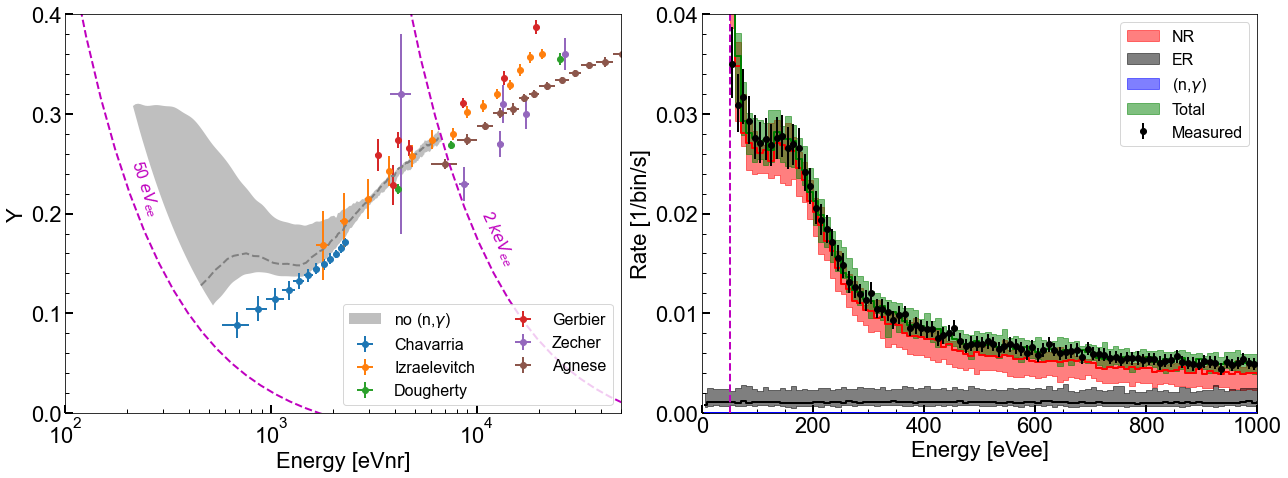

In [50]:
fig_w=9
fig,axs=subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))

cut=scanData['cgood']&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)

iPlot=0

#Best fit to Izr
iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]

labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['gray','green']

#Add other measurements from lit
pt.plotOldYs_noSat(axs[0],fmt='o',markersize=6)
axs[0].fill(*getEYenvelope(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=70),
            colors[iPlot],alpha=0.5,label=labels[iPlot])


axs[0].plot(scanData['lE_nrs'][iBest][Ebin_ctr>70],scanData['lYs'][iBest][Ebin_ctr>70], colors[iPlot], linestyle='--')

Yiso = lambda Enr,Eee: Eee/Enr*(1+eps/V)-eps/V
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),50),'--m')
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),2e3),'--m')

axs[0].text(2e2,0.2,r'50 $eV_{ee}$',size=16,color='m',rotation=-72)
axs[0].text(1e4,0.15,r'2 $keV_{ee}$',size=16,color='m',rotation=-65)

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T,
                ecolor='k', marker='o',markersize=6,color='k', linestyle='none',label='Measured',zorder=5)

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)


ERenvData=getERminmax_v3(scanData,cut,nAvg=1)
ERmidData=getERminmax_v3(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5)#Cheat to get mid. min==max

axs[1].step(ERmidData['eVee'],ERmidData['NR']['min'],color='r',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['ER']['min'],color='k',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['NG']['min'],color='b',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['Total']['min'],color='g',where='mid')

axs[1].fill_between(ERenvData['eVee'],ERenvData['NR']['min'],ERenvData['NR']['max'],color='r',alpha=0.5,step='mid',label='NR')
axs[1].fill_between(ERenvData['eVee'],ERenvData['ER']['min'],ERenvData['ER']['max'],color='k',alpha=0.5,step='mid',label='ER')
axs[1].fill_between(ERenvData['eVee'],ERenvData['NG']['min'],ERenvData['NG']['max'],color='b',alpha=0.5,step='mid',label=r'(n,$\gamma)$')
axs[1].fill_between(ERenvData['eVee'],ERenvData['Total']['min'],ERenvData['Total']['max'],color='g',alpha=0.5,step='mid',label='Total')

axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2,prop={'size': 16})

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.04)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs[1].set_xlim(0,1e3)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right', prop={'size': 16})

tight_layout()

In [51]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins

#v3: Separate ER and NR Fanos. Also allow smeared energies to be negative
#v4: Add dynamic smearing iteration. Stop if smeared matches measured via some measure of closeness.
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
#Single data structure to hold all those arrays of stuff

scanData={'lY_max':[], 'lfer':[], 'lfnr':[], 'lfng':[],
          'lE_nrs':[], 'lYs':[], 'lerrors':[], 'lFanoER':[],'lFanoNR':[],
          'lnItMax':[],'liIt':[]}
Y_max=0.25
FanoNR=0#0.1161
fnr=4
fng=4#2.037+0.41

for nIt in tqdm([0,1,2,5,10,15,20,30]):
    scanData['lnItMax'].append(nIt)
    scanData['lY_max'].append(Y_max)

    #Normalize near 2keV
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    fer=(R0_meas-fnr*R0_nr)/R0_er


    scanData['lfer'].append(fer)
    scanData['lfnr'].append(fnr)
    scanData['lfng'].append(fng)

    scanData['lFanoER'].append(0.1161)
    scanData['lFanoNR'].append(FanoNR)

    E_nrs,Ys,errors,iIt=extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                            nItMax=nIt, fit_frac_all_goal=0.83, Ebins=np.linspace(0,2e3,201),
                                            seed=0,FanoER=0.1161, FanoNR=FanoNR)
    scanData['liIt'].append(iIt)
    scanData['lE_nrs'].append(E_nrs)
    scanData['lYs'].append(Ys)
    scanData['lerrors'].append(errors)


for key in scanData.keys():
    scanData[key]=np.array(scanData[key])
    
scanData['N']=len(scanData['lY_max'])

  0%|          | 0/8 [00:00<?, ?it/s]

In [53]:
fig_w=9
seed=0

for i in range(scanData['N']):
    E_nrs=scanData['lE_nrs'][i]
    Ys=scanData['lYs'][i]
    fer=scanData['lfer'][i]
    fnr=scanData['lfnr'][i]
    fng=scanData['lfng'][i]
    FanoER=scanData['lFanoER'][i]
    FanoNR=scanData['lFanoNR'][i]
    
    Y=getYfitCond_v4(E_nrs,Ys)

    E_nr_eVee=NRtoER(E_nr,Y,V,eps)
    E_ng_eVee=NRtoER(E_ng,Y,V,eps)

    if nIt>0:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er

    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr

    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    R_tot=R_er+R_nr+R_ng

    R_max=R_meas[Ebin_ctr>50]+1*dR_meas[0][Ebin_ctr>50]
    R_min=R_meas[Ebin_ctr>50]-1*dR_meas[1][Ebin_ctr>50]

In [54]:
save = False
try:
    with open( "data/intmeth_prescan_v4.p", "rb" ) as file:
        temp = pickle.load( file )
        Y_max_test=temp['Y_max_test']
        fnr_test=temp['fnr_test']
        matchIzr_test=temp['matchIzr_test']
except:
    save = True

In [55]:
#Do a first pass w/o smearing to determine the set of Y_max,fnr values that are even close.
if save:    
    Y_max_test_1d=np.linspace(0.25,0.29,100)
    fnr_test_1d=np.linspace(4,9,100)
    Y_max_test,fnr_test= np.meshgrid(Y_max_test_1d,fnr_test_1d)
    Y_max_test=Y_max_test.flatten()
    fnr_test=fnr_test.flatten()

    matchIzr_test=[]
    for Y_max,fnr in zip(tqdm(Y_max_test),fnr_test):
        #Normalize near 2keV
        R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
        R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
        R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

        fer=(R0_meas-fnr*R0_nr)/R0_er

        E_nrs,Ys,errors,iIt=extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                                nItMax=0, fit_frac_all_goal=0.8, fit_frac_low_goal=1,
                                                Ebins=np.linspace(0,2e3,201),
                                                seed=None,FanoER=0.1161, FanoNR=0.1161)

        Y=getYfitCond_v4(E_nrs,Ys)
        cizr=izr['Enr']<E_nrs[-1]

        matchIzr_test.append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())

    matchIzr_test=np.array(matchIzr_test)
    temp={'Y_max_test':Y_max_test, 'fnr_test':fnr_test, 'matchIzr_test':matchIzr_test}
    with open( "data/intmeth_prescan_v4.p", "wb" ) as file:
        pickle.dump( temp, file )

In [56]:
save = False
try:
    with open( "data/intmeth_scan_v4.p", "rb" ) as file:
        scanData = pickle.load( file )
except:
    save=True

In [57]:
#Calculate using those initally good pairs of values
# But now we'll allow a few rounds of smearing and try different fng and FanoNR values.
if save:
    #Single data structure to hold all those arrays of stuff
    scanData={'lY_max':[], 'lfer':[], 'lfnr':[], 'lfng':[],
              'lE_nrs':[], 'lYs':[], 'lerrors':[], 'lFanoER':[],'lFanoNR':[],
              'lnItMax':[],'liIt':[]}
    nItMax=4

    for Y_max,fnr in zip(tqdm(Y_max_test[matchIzr_test]),fnr_test[matchIzr_test]):
            for fng in [0,2.037+0.408,2.037,2.037-0.408]:
                for FanoNR in [0.1161,1,2,5]:

                    scanData['lnItMax'].append(nItMax)
                    scanData['lY_max'].append(Y_max)

                    #Normalize near 2keV
                    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
                    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
                    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

                    fer=(R0_meas-fnr*R0_nr)/R0_er


                    scanData['lfer'].append(fer)
                    scanData['lfnr'].append(fnr)
                    scanData['lfng'].append(fng)

                    scanData['lFanoER'].append(0.1161)
                    scanData['lFanoNR'].append(FanoNR)

                    E_nrs,Ys,errors,iIt=extract_Y_wSmear_v4(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                                            nItMax=nItMax, fit_frac_all_goal=0.8, fit_frac_low_goal=1,
                                                            Ebins=np.linspace(0,2e3,201),
                                                            seed=None,FanoER=0.1161, FanoNR=FanoNR)
                    scanData['liIt'].append(iIt)
                    scanData['lE_nrs'].append(E_nrs)
                    scanData['lYs'].append(Ys)
                    scanData['lerrors'].append(errors)


    for key in scanData.keys():
        scanData[key]=np.array(scanData[key])

    scanData['N']=len(scanData['lY_max'])
    
    with open( "data/intmeth_scan_v4.p", "wb" ) as file:
        pickle.dump( scanData, file )

In [58]:
#Find those which are consistent with Izr
save = True

if save:
    scanData['cgood']=[]
    scanData['IzrChi']=[]
    scanData['Y1keV']=[]

    for i in zip(range(scanData['N'])):
        Y=getYfitCond_v4(scanData['lE_nrs'][i],scanData['lYs'][i])
        cizr=izr['Enr']<scanData['lE_nrs'][i][-1]

        scanData['Y1keV'].append(Y.calc(np.array([1e3])))
        scanData['IzrChi'].append(np.sum((((Y.calc(izr['Enr'])-izr['Y'])/izr['dY'])[cizr])**2))
        scanData['cgood'].append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())

    scanData['cgood']=np.array(scanData['cgood'])
    scanData['IzrChi']=np.array(scanData['IzrChi'])
    scanData['Y1keV']=np.array(scanData['Y1keV'])
    with open( "data/intmeth_scan_v5.p", "wb" ) as file:
        pickle.dump( scanData, file )

In [59]:
#Collect the things we want to plot since it can take a while
EYenvelopes=[]
ERenvData=[]
ERmidData=[]
iBest=[]

mask=np.zeros(len(cut),dtype=bool)
mask[:]=True

#No NG
cut_noNG=(scanData['cgood'])&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)

In [60]:
iBest=[]

cut_noNG=(scanData['cgood'])&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)

In [61]:
#NR equivalent threshold values for some yield models
#Also compare with arb threshold of 10 eVee

#Lindhard (k=0.146 for Si)
Y=Yield.Yield('Lind',[0.146])

In [62]:
#Should really put these calculations somewhere more useful
#Lindhard for Ge (Si) at 100(110) eV, that's the assumed SNOLAB iZIP threshold
Y=Yield.Yield('Lind',[0.157]) #Used <A>=72.8

Y=Yield.Yield('Lind',[0.146])

In [63]:
importlib.reload(pt)

<module 'R68_plot_tools' from '../python/R68_plot_tools.py'>

In [64]:
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)

Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

#uncertainty is (high,low)
R_meas,dR_meas=spec.doBkgSub(meas, Ebins, Efit_min=50,Efit_max=2e3,\
                             doEffsyst=True, doBurstLeaksyst=True,\
                             output='reco-rate')

../python/R68_spec_tools.py:55: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:60: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/TE_Bkg


In [65]:
#Illustration of method

Elim_er=[255.0,505.0,1005.0,1505.0,1995.0]
Elim_nr=[806.3832567888599, 1967.2490338155576, 4045.3075738134753, 5739.940139258986, 7281.31517699986]

for Elim in Elim_er[:-1]:
    cut=(Ebin_ctr>=Elim)&(Ebin_ctr<=Elim_er[-1])

In [66]:
c,b=np.histogram(np.sum(g4['ER']['E'],axis=1),bins=Ebins)
bctr=(b[:-1]+b[1:])/2

for Elim in Elim_er[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_er[-1])

Ebnr=np.linspace(0,7.3e3,200)
c,b=np.histogram(np.sum(g4['NR']['E'],axis=1),bins=Ebnr)
bctr=(b[:-1]+b[1:])/2

for Elim in Elim_nr[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_nr[-1])

c,b=np.histogram(np.sum(cap['dE'],axis=1),bins=Ebnr)
bctr=(b[:-1]+b[1:])/2

for Elim in Elim_nr[:-1]:
    cut=(bctr>=Elim)&(bctr<=Elim_nr[-1])

In [67]:
#For this analysis, we'll just use the total Edep of each event and apply yield to that.
#How big of an assumption is this?
E_er=np.sum(g4['ER']['E'],axis=1)
E_nr=np.sum(g4['NR']['E'],axis=1)
E_ng=np.sum(cap['dE'],axis=1)

In [68]:
Emax_frac_er=np.max(g4['ER']['E'],axis=1)/np.sum(g4['ER']['E'],axis=1)
Emax_frac_nr=np.max(g4['NR']['E'],axis=1)/np.sum(g4['NR']['E'],axis=1)
Emax_frac_ng=np.max(cap['dE'],axis=1)/np.sum(cap['dE'],axis=1)

In [69]:
#Trim events that won't figure into the analysis range
E_er=E_er[(E_er>0) & (E_er<10e3)]
E_nr=E_nr[(E_nr>0) & (E_nr<1000e3)]

In [70]:
#Spectra with default livetimes and standard yield, Fano

#Y=Yield.Yield('Lind',[0.146])
Y=Yield.Yield('Chav',[0.146,1e3/0.247])

N_er,_=np.histogram(E_er,bins=Ebins)
N_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
N_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)

R_er=N_er/g4['ER']['tlive']
R_nr=N_nr/g4['NR']['tlive']
R_ng=N_ng/cap['tlive']

In [71]:
#Need to set some NR max I think. 
#Not sure how to choose this because there's NRs up to 1 MeV
#Do we need a fixed (Er,Y) to work from?

Y=Yield.Yield('Lind',[0.146])
E_nr_max=ERtoNR(Ebin_ctr[-1],Y,V,eps)[0]

fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y,V,eps)[0],E_nr_max)/g4['NR']['tlive'])
fng=0

E_nrs=[]
E_nr_step=1
E_nr_test=E_nr_max
for i in tqdm(range(len(Ebin_ctr))[::-1]):
    if np.isfinite(R_meas[i]):
        while True:
            R_meas_this=np.sum(R_meas[(Ebin_ctr>Ebin_ctr[i])&(Ebin_ctr<2e3)])
            R_sim_this=fg4*(Nint(E_er,Ebin_ctr[i],2e3)/g4['ER']['tlive'] + Nint(E_nr,E_nr_test,E_nr_max)/g4['NR']['tlive']) + fng*Nint(E_ng,E_nr_test,E_nr_max)/cap['tlive']

            if (R_meas_this<R_sim_this) or (E_nr_test<0):
                break
            E_nr_test-=E_nr_step
            
        E_nrs.append(E_nr_test)
    else:
        E_nrs.append(np.inf)
E_nrs=np.array(E_nrs[::-1])

  0%|          | 0/200 [00:00<?, ?it/s]

In [72]:
Ys=((Ebin_ctr/E_nrs)*(1+V/eps)-1)*eps/V

cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit])

Y=Yield.Yield('Chav',[0.146,1e3/0.247])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1281: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [73]:
C_er,_=np.histogram(E_er,bins=Ebins)
R_er=fg4*C_er/g4['ER']['tlive']

Y=Yield.Yield('User',[Y_fCS])
C_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
R_nr=fg4*C_nr/g4['NR']['tlive']
C_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)
R_ng=fng*C_ng/cap['tlive']

In [74]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

In [75]:
lY_max=np.linspace(0.1,0.6,6)
lfer=[]
lfnr=[]
lE_nrs=[]
lYs=[]
for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV
    fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
    lfer.append(fg4)
    lfnr.append(fg4)
    E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=0, Y_max=Y_max, E_nr_step=1)
    lE_nrs.append(E_nrs)
    lYs.append(Ys)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [76]:
for E_nrs,Ys in zip(lE_nrs,lYs):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

for E_nrs,Ys,fer,fnr in zip(lE_nrs,lYs,lfer,lfnr):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    C_er,_=np.histogram(E_er,bins=Ebins)
    R_er=fer*C_er/tlive_er
    Y=Yield.Yield('User',[Y_fCS])
    C_nr,_=np.histogram(NRtoER(E_nr,Y,V,eps),bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(NRtoER(E_ng,Y,V,eps),bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

In [77]:
bins=np.linspace(-100,2500,100)
#Looks like that's doing the right thing. Maybe need to truncate at 0
ERsmeared=spec.getSmeared(NRtoER(E_ng,0.2,V,eps))
ERsmeared[ERsmeared<0]=0

In [78]:
Y_max=0.25
#Normalize so that ER+NR matches data near 2 keV
fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])

E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)
cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [79]:
Y=Yield.Yield('User',[Y_fit])
E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
ERtoNR_fCS=CubicSpline(NRtoER(E_nrs[cFit],Y,V,eps),E_nrs[cFit])

E_nr_sm=ERtoNR_fCS(spec.getSmeared(E_nr_eVee))
E_ng_sm=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))
E_ng_sm2=ERtoNR_fCS(spec.getSmeared(E_ng_eVee))

Ebnr=np.linspace(0,3e3,200)

In [80]:
E_nrs_0=E_nrs
Ys_0=Ys
E_nrs,Ys=extract_Y(E_er, E_nr_sm, E_ng_sm, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)
cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [81]:
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

In [82]:
Y_max=0.25
#Normalize so that ER+NR matches data near 2 keV
fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])

E_nrs,Ys=extract_Y(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, E_nr_step=1)

cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[E_nrs>0][0],0,E_nrs[-1],Ys[-1])

E_nrs,Ys=extract_Y_wSmear(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max, nIt=1, E_nr_step=1)

cFit=(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[E_nrs>0][0],0,E_nrs[-1],Ys[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [83]:
lY_max=[0.3]
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV
    fg4=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)]) / (Nint(E_er,1.9e3,2e3)/g4['ER']['tlive'] + Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive'])
    lfer.append(fg4)
    lfnr.append(fg4)
    lfng.append(1)
    E_nrs,Ys=extract_Y_wSmear(E_er, E_nr, E_ng, fer=fg4, fnr=fg4, fng=1, Y_max=Y_max,
                              nIt=1, E_nr_step=1)
    lE_nrs.append(E_nrs)
    lYs.append(Ys)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [84]:
for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs,lYs,lfer,lfnr,lfng):
    cFit=(np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    #Smear
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[0],0,E_nrs[-1],Ys[-1])
    Y=Yield.Yield('User',[Y_fit])
    
    E_er_sm=spec.getSmeared(E_er)
    E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps))
    E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps))
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

In [85]:
Y_max=0.3

R0_meas=np.sum(R_meas[(Ebin_ctr>1.9e3)&(Ebin_ctr<2e3)])
R0_er=Nint(E_er,1.9e3,2e3)/g4['ER']['tlive']
R0_nr=Nint(E_nr,ERtoNR(1.9e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

fer=0
fnr=(R0_meas)/R0_nr
fng=0

E_er_max=2e3
E_nr_max=ERtoNR(E_er_max,Y_max,V,eps)

Ebin_ctr_rev=Ebin_ctr[::-1]

rev_csum_meas=np.cumsum(R_meas[::-1])

R_sim_er=fer*np.histogram(E_er,Ebins)[0]/tlive_er
rev_csum_er=np.cumsum(R_sim_er[::-1])

w_nr=fnr/tlive_nr*np.ones(np.sum(E_nr<=E_nr_max))
w_ng=fng/tlive_ng*np.ones(np.sum(E_ng<=E_nr_max))

E_nrng=np.concatenate((E_nr[E_nr<=E_nr_max],E_ng[E_ng<=E_nr_max]))
w_nrng=np.concatenate((w_nr,w_ng))

E_nrng_rev_srt=(E_nrng[np.argsort(E_nrng)])[::-1]
w_nrng_rev_srt=(w_nrng[np.argsort(E_nrng)])[::-1]
rev_csum_nrng=np.cumsum(w_nrng_rev_srt)

diff=rev_csum_meas-rev_csum_er
E_nrs=[]
error=[]
for entry in diff:
    if np.isfinite(entry):
        args=np.argwhere(rev_csum_nrng>=entry)
        if len(args)==0:
            E_nrs.append(-99)
        else:
            E_nr_this=E_nrng_rev_srt[args[0][0]]
            error.append(rev_csum_nrng[args[0][0]]-entry)
            if len(E_nrs)>0:
                E_nrs.append(min(E_nr_this,E_nrs[-1]))
            else:
                E_nrs.append(E_nr_this)
    else:
        E_nrs.append(-999)
        error.append(-999)
E_nrs=np.array(E_nrs[::-1])
Ys=((Ebins[:-1]/E_nrs)*(1+V/eps)-1)*eps/V

In [86]:
cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

E_er_sm=E_er
E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)

C_er,_=np.histogram(E_er_sm,bins=Ebins)
R_er=fer*C_er/tlive_er
C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
R_nr=fnr*C_nr/tlive_nr
C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
R_ng=fng*C_ng/tlive_ng

In [87]:
E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm=spec.getSmeared(E_er,seed=None,F=F)
E_er_sm[E_er_sm<0]=0
E_nr_sm=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
E_ng_sm=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))

In [88]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm2=spec.getSmeared(E_er,seed=None,F=F)
E_nr_sm2=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
E_ng_sm2=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))

../python/R68_spec_tools.py:69: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(dTE_Bkg/TE_Bkg)**2 )


In [89]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm2, E_nr_sm2, E_ng_sm2, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

E_nr_eVee=NRtoER(E_nr,Y,V,eps)
E_ng_eVee=NRtoER(E_ng,Y,V,eps)

#Use this correspondence to map back to NR
#But need to condition it outside of the spline region.
#Just extrapolate with linear from each end
xx=NRtoER(E_nrs[cFit],Y,V,eps)
yy=E_nrs[cFit]
ERtoNR_fCS=CubicSpline(xx,yy,extrapolate=True)
pf_low=np.poly1d(np.polyfit([0,xx[0]], [0,yy[0]], 1))
pf_hi=np.poly1d(np.polyfit(xx[-10:], yy[-10:], 1))
ERtoNR_fcombo = lambda E: (E<xx[0])*pf_low(E) + (E>=xx[0])*(E<=xx[-1])*ERtoNR_fCS(E) + (E>xx[-1])*pf_hi(E)

E_er_sm3=spec.getSmeared(E_er,seed=None,F=F)
E_nr_sm3=ERtoNR_fcombo(spec.getSmeared(E_nr_eVee,seed=None,F=F))
E_ng_sm3=ERtoNR_fcombo(spec.getSmeared(E_ng_eVee,seed=None,F=F))

In [90]:
E_nrs,Ys,errors=extract_Y_v2(E_er_sm, E_nr_sm, E_ng_sm, fer, fnr, fng, Y_max, Ebins)

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
Y=Yield.Yield('User',[Y_fit])

In [91]:
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

lY_max=np.linspace(0.2,0.3,5)
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
lerrors=[]

for Y_max in tqdm(lY_max):
    #Normalize so that ER+NR matches data near 2 keV

    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    fnr=6
    fer=(R0_meas-fnr*R0_nr)/R0_er
    fng=2#2.037

    lfer.append(fer)
    lfnr.append(fnr)
    lfng.append(fng)
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=1, Ebins=np.linspace(0,2e3,201), seed=None)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

  0%|          | 0/5 [00:00<?, ?it/s]

In [92]:
dosmear=True
seed=None

#Add other measurements from lit
for E_nrs,Ys,fer,fnr,fng in zip(lE_nrs,lYs,lfer,lfnr,lfng):
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    
    #Smear
    Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
    Y=Yield.Yield('User',[Y_fit])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [93]:
#lnIt=np.arange(11)
lnIt=[0,1,2,5,10,15,20,30]
lY_max=[]
lfer=[]
lfnr=[]
lfng=[]
lE_nrs=[]
lYs=[]
lerrors=[]

for nIt in tqdm(lnIt):

    Y_max=0.25
    
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']
    
    
    lY_max.append(Y_max)
    fnr=6
    fer=(R0_meas-fnr*R0_nr)/R0_er
    fng=4#2.037+0.41

    lfer.append(fer)
    lfnr.append(fnr)
    lfng.append(fng)
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=nIt, Ebins=np.linspace(0,2e3,201), seed=None)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

  0%|          | 0/8 [00:00<?, ?it/s]

In [94]:
dosmear=True
seed=None

#Add other measurements from lit

for E_nrs,Ys,fer,fnr,fng,nIt in zip(lE_nrs,lYs,lfer,lfnr,lfng,lnIt):
    
    cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])
    
    #Smear
    Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
    
    Y=Yield.Yield('User',[Y_fit])
    
    if nIt>0:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [95]:
E_nrs=lE_nrs[4]
Ys=lYs[4]

cFit=(Ebin_ctr>50) & (E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
Y_fCS=lambda E: np.interp(E,E_nrs[cFit],Ys[cFit])

#Smear
Y_fit = lambda E: Y_conditioned_test(E,Y_fCS,E_nrs[cFit],Ys[cFit])
Y=Yield.Yield('User',[Y_fit])

In [96]:
lY_max=np.concatenate((np.linspace(0.2,0.3,5),np.linspace(0.2,0.3,5)))
lfer=[]
lfnr=[]
lfng=np.concatenate(((2.037+0.408)*np.ones(5),(2.037-0.408)*np.ones(5)))
lE_nrs=[]
lYs=[]
lerrors=[]

for Y_max,fng in zip(tqdm(lY_max),lfng):
    #Normalize near 2keV
    R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
    R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
    R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

    fer=(R0_meas)/(R0_er+R0_nr)
    fnr=fer

    lfer.append(fer)
    lfnr.append(fnr)
    
    E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                              nIt=1, Ebins=np.linspace(0,2e3,201), seed=0)
    #If binning is too small, will get some errors and things won't work.
    #Probably in bkg_sub, but not exactly sure
    lE_nrs.append(E_nrs)
    lYs.append(Ys)
    lerrors.append(errors)

lfer=np.array(lfer)
lfnr=np.array(lfnr)
lE_nrs=np.array(lE_nrs)
lYs=np.array(lYs)
lerrors=np.array(lerrors)

  0%|          | 0/10 [00:00<?, ?it/s]

In [97]:
dosmear=True
seed=0

#Add other measurements from lit

N=len(lE_nrs)
for i in range(int(N/2)):    
    
    cFit1=(Ebin_ctr>50) &(lE_nrs[i]>0) & (np.isfinite(lE_nrs[i])) & (np.insert(np.diff(lE_nrs[i])>0,-1,True))
    E_nrs1=lE_nrs[i][cFit1]
    Ys1=lYs[i][cFit1]
    Y_fCS1=CubicSpline(E_nrs1,Ys1,extrapolate=True)
    
    cFit2=(Ebin_ctr>50) &(lE_nrs[i+int(N/2)]>0) & (np.isfinite(lE_nrs[i+int(N/2)])) & (np.insert(np.diff(lE_nrs[i+int(N/2)])>0,-1,True))
    E_nrs2=lE_nrs[i+int(N/2)][cFit2]
    Ys2=lYs[i+int(N/2)][cFit2]
    Y_fCS2=CubicSpline(E_nrs2,Ys2,extrapolate=True)
    
    #Smear
    
    Y_fit1 = lambda E: Y_conditioned(E,Y_fCS1,E_nrs1[0],Ys1[0],E_nrs1[-1],Ys1[-1])
    Y1=Yield.Yield('User',[Y_fit1])
    Y_fit2 = lambda E: Y_conditioned(E,Y_fCS2,E_nrs2[0],Ys2[0],E_nrs2[-1],Ys2[-1])
    Y2=Yield.Yield('User',[Y_fit2])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y1,V,eps),seed=seed)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_nr_sm=NRtoER(E_nr,Y1,V,eps)
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y1,V,eps),seed=seed)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y1,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y1,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=lfer[i]*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=lfnr[i]*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=lfng[i]*C_ng/tlive_ng
    
    R_tot=R_er+R_nr+R_ng
    chi=np.mean((((R_tot-R_meas)/((dR_meas[0]+dR_meas[1])/2))**2)[Ebin_ctr>50])

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [98]:
izr=pt.get_old_Y_data()
Y_izr_up=CubicSpline(izr['Enr'],izr['Y'],extrapolate=True)

Y_fit = lambda E: Y_conditioned(E,Y_izr_up,izr['Enr'][0],(izr['Y'])[0],izr['Enr'][-1],(izr['Y'])[-1])
Y=Yield.Yield('User',[Y_fit])
xx=np.linspace(0,30e3,1000)

In [99]:
#Let's scan through a bunch of scalings and then only retain those which are consistent with Izr
save = True

if save:
    lY_max=[]
    lfer=[]
    lfnr=[]
    lfng=[]
    lE_nrs=[]
    lYs=[]
    lerrors=[]

    for Y_max in tqdm(np.linspace(0.25,0.29,20)):
        for fnr in np.linspace(4,9,20):
            for fng in [0,2.037+0.408,2.037-0.408]:

                lY_max.append(Y_max)
                #Normalize near 2keV
                R0_meas=np.sum(R_meas[(Ebin_ctr>1.99e3)&(Ebin_ctr<2e3)])
                R0_er=Nint(E_er,1.99e3,2e3)/g4['ER']['tlive']
                R0_nr=Nint(E_nr,ERtoNR(1.99e3,Y_max,V,eps),ERtoNR(2e3,Y_max,V,eps))/g4['NR']['tlive']

                fer=(R0_meas-fnr*R0_nr)/R0_er

                lfer.append(fer)
                lfnr.append(fnr)
                lfng.append(fng)

                E_nrs,Ys,errors=extract_Y_wSmear_v2(E_er, E_nr, E_ng, fer, fnr, fng, Y_max=Y_max,
                                          nIt=1, Ebins=np.linspace(0,2e3,201), seed=0, F=0.1161)
                #If binning is too small, will get some errors and things won't work.
                #Probably in bkg_sub, but not exactly sure
                lE_nrs.append(E_nrs)
                lYs.append(Ys)
                lerrors.append(errors)

    lY_max=np.array(lY_max)
    lfer=np.array(lfer)
    lfnr=np.array(lfnr)
    lfng=np.array(lfng)
    lE_nrs=np.array(lE_nrs)
    lYs=np.array(lYs)
    lerrors=np.array(lerrors)
    results={'lY_max':lY_max, 'lfer':lfer, 'lfnr':lfnr, 'lfng':lfng, 'lE_nrs':lE_nrs, 'lYs':lYs, 'lerrors':lerrors}
    with open( "data/cdf_results.p", "wb" ) as file:
        pickle.dump( results, file )

  0%|          | 0/20 [00:00<?, ?it/s]

In [100]:
#Find those which are consistent with Izr
cgood=[]
Y_1keV=[]
for E_nrs,Ys in zip(lE_nrs,lYs):
    Y=getYfitCond(E_nrs,Ys)
    
    cizr=izr['Enr']<E_nrs[-1]
    Y_1keV.append(Y.calc(1e3))
    
    cgood.append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
cgood=np.array(cgood)
Y_1keV=np.array(Y_1keV)

In [101]:
dosmear=True
seed=0
Fthis=0.1161

#Add other measurements from lit

for E_nrs,Ys,fer,fnr,fng,good in zip(lE_nrs,lYs,lfer,lfnr,lfng,cgood):
    if not good:
        continue
    cFit=(Ebin_ctr>50) &(E_nrs>0) & (np.isfinite(E_nrs)) & (np.insert(np.diff(E_nrs)>0,-1,True))
    Y_fCS=CubicSpline(E_nrs[cFit],Ys[cFit],extrapolate=True)
    
    if fng==0:
        color='red'
    else:
        color='gray'
    
    #Smear
    Y_fit = lambda E: Y_conditioned(E,Y_fCS,E_nrs[cFit][0],Ys[cFit][0],E_nrs[-1],Ys[-1])
    Y=Yield.Yield('User',[Y_fit])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=Fthis)
        E_er_sm[E_er_sm<0]=0
        E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm[E_nr_eVee_sm<0]=0
        E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm[E_ng_eVee_sm<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)
    
    C_er,_=np.histogram(E_er_sm,bins=Ebins)
    R_er=fer*C_er/tlive_er
    C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
    R_nr=fnr*C_nr/tlive_nr
    C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
    R_ng=fng*C_ng/tlive_ng

In [102]:
#Pick mins and maxes at a given energy
#This isn't quite right, since envelope is not jsut from a single curve

ifng0=np.argwhere(cgood&(lfng==0))
ifng0_min=ifng0[np.argmin(Y_1keV[ifng0])][0]
ifng0_max=ifng0[np.argmax(Y_1keV[ifng0])][0]

ifng=np.argwhere(cgood&(lfng!=0))
ifng_min=ifng[np.argmin(Y_1keV[ifng])][0]
ifng_max=ifng[np.argmax(Y_1keV[ifng])][0]

In [103]:
dosmear=True
seed=0
Fthis=0.1161

#Add other measurements from lit

labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['red','gray']

for inds,label,color in zip([[ifng0_max,ifng0_min],[ifng_max,ifng_min]],labels,colors):
#for E_nrs,Ys,fer,fnr,fng,good in zip(lE_nrs,lYs,lfer,lfnr,lfng,cgood):

    i=inds[0]
    j=inds[1]
    
    cFit1=(Ebin_ctr>50) &(lE_nrs[i]>0) & (np.isfinite(lE_nrs[i])) & (np.insert(np.diff(lE_nrs[i])>0,-1,True))
    E_nrs1=lE_nrs[i][cFit1]
    Ys1=lYs[i][cFit1]
    Y_fCS1=CubicSpline(E_nrs1,Ys1,extrapolate=True)
    
    cFit2=(Ebin_ctr>50) &(lE_nrs[j]>0) & (np.isfinite(lE_nrs[j])) & (np.insert(np.diff(lE_nrs[j])>0,-1,True))
    E_nrs2=lE_nrs[j][cFit2]
    Ys2=lYs[j][cFit2]
    Y_fCS2=CubicSpline(E_nrs2,Ys2,extrapolate=True)
    
    #Smear
    Y_fit1 = lambda E: Y_conditioned(E,Y_fCS1,E_nrs1[0],Ys1[0],E_nrs1[-1],Ys1[-1])
    Y1=Yield.Yield('User',[Y_fit1])
    Y_fit2 = lambda E: Y_conditioned(E,Y_fCS2,E_nrs2[0],Ys2[0],E_nrs2[-1],Ys2[-1])
    Y2=Yield.Yield('User',[Y_fit2])
    
    if dosmear:
        E_er_sm=spec.getSmeared(E_er,seed=seed,F=Fthis)
        E_er_sm[E_er_sm<0]=0
        
        E_nr_eVee_sm1=spec.getSmeared(NRtoER(E_nr,Y1,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm1[E_nr_eVee_sm1<0]=0
        E_nr_eVee_sm2=spec.getSmeared(NRtoER(E_nr,Y2,V,eps),seed=seed,F=Fthis)
        E_nr_eVee_sm2[E_nr_eVee_sm2<0]=0
        
        E_ng_eVee_sm1=spec.getSmeared(NRtoER(E_ng,Y1,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm1[E_ng_eVee_sm1<0]=0
        E_ng_eVee_sm2=spec.getSmeared(NRtoER(E_ng,Y2,V,eps),seed=seed,F=Fthis)
        E_ng_eVee_sm2[E_ng_eVee_sm2<0]=0
    else:
        E_er_sm=E_er
        E_nr_eVee_sm1=NRtoER(E_nr,Y1,V,eps)
        E_nr_eVee_sm2=NRtoER(E_nr,Y2,V,eps)
        E_ng_eVee_sm1=NRtoER(E_ng,Y1,V,eps)
        E_ng_eVee_sm2=NRtoER(E_ng,Y2,V,eps)
    
    C_er1,_=np.histogram(E_er_sm,bins=Ebins)
    R_er1=lfer[i]*C_er1/tlive_er
    C_er2,_=np.histogram(E_er_sm,bins=Ebins)
    R_er2=lfer[j]*C_er2/tlive_er
    
    C_nr1,_=np.histogram(E_nr_eVee_sm1,bins=Ebins)
    R_nr1=lfnr[i]*C_nr1/tlive_nr
    C_nr2,_=np.histogram(E_nr_eVee_sm2,bins=Ebins)
    R_nr2=lfnr[j]*C_nr2/tlive_nr
    
    C_ng1,_=np.histogram(E_ng_eVee_sm1,bins=Ebins)
    R_ng1=lfng[i]*C_ng1/tlive_ng
    C_ng2,_=np.histogram(E_ng_eVee_sm2,bins=Ebins)
    R_ng2=lfng[j]*C_ng2/tlive_ng

In [104]:
cut=cgood&(lfng!=0)
ERenvData=getERminmax(lE_nrs[cut],lYs[cut],lfer[cut],lfnr[cut],lfng[cut])

In [105]:
cut=cgood&(lfng!=0)
cut=cgood&(lfng==0)

#Add other measurements from lit
ERenvData=getERminmax(lE_nrs[cut],lYs[cut],lfer[cut],lfnr[cut],lfng[cut])

In [106]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins

#v3: Separate ER and NR Fanos. Also allow smeared energies to be negative

tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

In [107]:
#Find those which are consistent with Izr
scanData['cgood']=[]
scanData['IzrChi']=[]

for i in zip(range(scanData['N'])):
    Y=getYfitCond(scanData['lE_nrs'][i],scanData['lYs'][i])
    cizr=izr['Enr']<scanData['lE_nrs'][i][-1]

    scanData['IzrChi'].append(np.sum((((Y.calc(izr['Enr'])-izr['Y'])/izr['dY'])[cizr])**2))
    scanData['cgood'].append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())
    
scanData['cgood']=np.array(scanData['cgood'])
scanData['IzrChi']=np.array(scanData['IzrChi'])

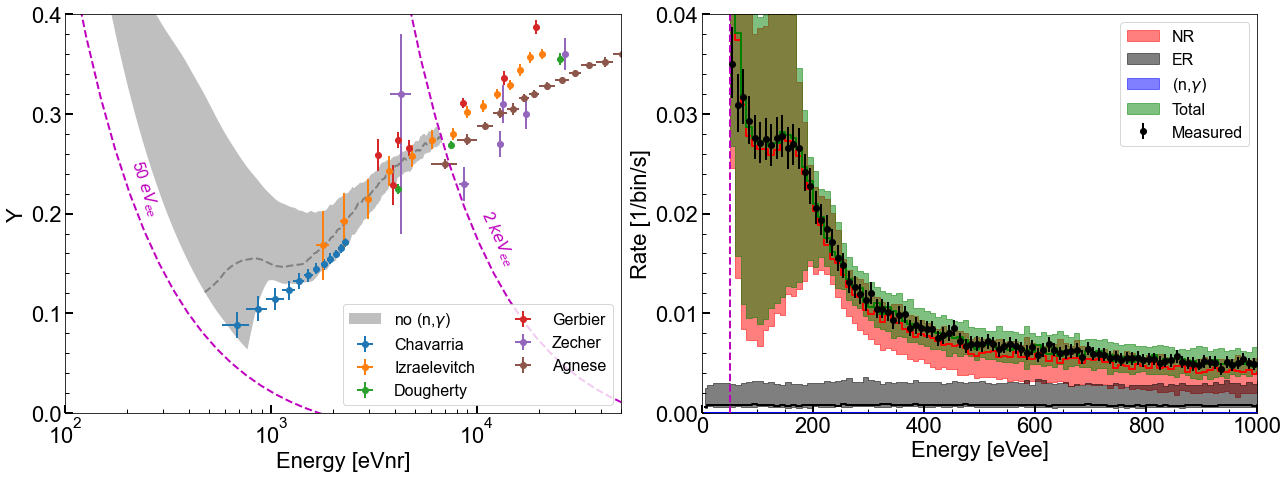

In [108]:
fig_w=9
fig,axs=subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))

cut=scanData['cgood']&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)

iPlot=0

#Best fit to Izr
iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]

labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['gray','green']

#Add other measurements from lit
pt.plotOldYs_noSat(axs[0],fmt='o',markersize=6)
axs[0].fill(*getEYenvelope(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=70),
            colors[iPlot],alpha=0.5,label=labels[iPlot])


axs[0].plot(scanData['lE_nrs'][iBest][Ebin_ctr>70],scanData['lYs'][iBest][Ebin_ctr>70], colors[iPlot], linestyle='--')

Yiso = lambda Enr,Eee: Eee/Enr*(1+eps/V)-eps/V
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),50),'--m')
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),2e3),'--m')

axs[0].text(2e2,0.2,r'50 $eV_{ee}$',size=16,color='m',rotation=-72)
axs[0].text(1e4,0.15,r'2 $keV_{ee}$',size=16,color='m',rotation=-65)

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T,
                ecolor='k', marker='o',markersize=6,color='k', linestyle='none',label='Measured',zorder=5)

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)


ERenvData=getERminmax_v3(scanData,cut,nAvg=1)
ERmidData=getERminmax_v3(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5)#Cheat to get mid. min==max

axs[1].step(ERmidData['eVee'],ERmidData['NR']['min'],color='r',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['ER']['min'],color='k',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['NG']['min'],color='b',where='mid')
axs[1].step(ERmidData['eVee'],ERmidData['Total']['min'],color='g',where='mid')

axs[1].fill_between(ERenvData['eVee'],ERenvData['NR']['min'],ERenvData['NR']['max'],color='r',alpha=0.5,step='mid',label='NR')
axs[1].fill_between(ERenvData['eVee'],ERenvData['ER']['min'],ERenvData['ER']['max'],color='k',alpha=0.5,step='mid',label='ER')
axs[1].fill_between(ERenvData['eVee'],ERenvData['NG']['min'],ERenvData['NG']['max'],color='b',alpha=0.5,step='mid',label=r'(n,$\gamma)$')
axs[1].fill_between(ERenvData['eVee'],ERenvData['Total']['min'],ERenvData['Total']['max'],color='g',alpha=0.5,step='mid',label='Total')

axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2,prop={'size': 16})

axs[1].axvline(50,linestyle='--',color='m')

axs[1].set_ylim(0,0.04)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs[1].set_xlim(0,1e3)
axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right', prop={'size': 16})

tight_layout()

In [109]:
#Extract yield curve using the integral method
#Treats each event as a single scatter of the total energy
#fer: ER livetime factor
#fnr: NR livetime factor
#fng: NG livetime factor
#Y_max: Yield value that corresponds to the highest bin edge of Ebins

#v3: Separate ER and NR Fanos. Also allow smeared energies to be negative
#v4: Add dynamic smearing iteration. Stop if smeared matches measured via some measure of closeness.
tlive_er=g4['ER']['tlive']
tlive_nr=g4['NR']['tlive']
tlive_ng=cap['tlive']

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
fig_w=9
seed=0

save = True

#Tried speeding this up by only including the last entry as intermediate ones aren't saved
#But that resulted in errors later on... :/
if save:
    for i in range(scanData['N']):
        E_nrs=scanData['lE_nrs'][i]
        Ys=scanData['lYs'][i]
        fer=scanData['lfer'][i]
        fnr=scanData['lfnr'][i]
        fng=scanData['lfng'][i]
        FanoER=scanData['lFanoER'][i]
        FanoNR=scanData['lFanoNR'][i]

        Y=getYfitCond_v4(E_nrs,Ys)

        E_nr_eVee=NRtoER(E_nr,Y,V,eps)
        E_ng_eVee=NRtoER(E_ng,Y,V,eps)

        if nIt>0:
            E_er_sm=spec.getSmeared(E_er,seed=seed,F=FanoER)
            E_nr_eVee_sm=spec.getSmeared(NRtoER(E_nr,Y,V,eps),seed=seed,F=FanoNR)
            E_ng_eVee_sm=spec.getSmeared(NRtoER(E_ng,Y,V,eps),seed=seed,F=FanoNR)
        else:
            E_er_sm=E_er
            E_nr_eVee_sm=NRtoER(E_nr,Y,V,eps)
            E_ng_eVee_sm=NRtoER(E_ng,Y,V,eps)


        C_er,_=np.histogram(E_er_sm,bins=Ebins)
        R_er=fer*C_er/tlive_er

        C_nr,_=np.histogram(E_nr_eVee_sm,bins=Ebins)
        R_nr=fnr*C_nr/tlive_nr

        C_ng,_=np.histogram(E_ng_eVee_sm,bins=Ebins)
        R_ng=fng*C_ng/tlive_ng

        R_tot=R_er+R_nr+R_ng

        R_max=R_meas[Ebin_ctr>50]+1*dR_meas[0][Ebin_ctr>50]
        R_min=R_meas[Ebin_ctr>50]-1*dR_meas[1][Ebin_ctr>50]

        with open( "data/R_Cal.p" , "wb" ) as file:
            temp = {'R_er':R_er, 'R_nr':R_nr, 'R_ng':R_ng, 'R_tot':R_tot, 'R_max':R_max, 'R_min': R_min}
            pickle.dump( temp, file )

In [111]:
#How many are a good match?
np.sum(matchIzr_test)

895

In [112]:
#Find those which are consistent with Izr
save = True

if save:
    scanData['cgood']=[]
    scanData['IzrChi']=[]
    scanData['Y1keV']=[]

    for i in zip(range(scanData['N'])):
        Y=getYfitCond_v4(scanData['lE_nrs'][i],scanData['lYs'][i])
        cizr=izr['Enr']<scanData['lE_nrs'][i][-1]

        scanData['Y1keV'].append(Y.calc(np.array([1e3])))
        scanData['IzrChi'].append(np.sum((((Y.calc(izr['Enr'])-izr['Y'])/izr['dY'])[cizr])**2))
        scanData['cgood'].append(((np.abs(Y.calc(izr['Enr'])-izr['Y'])<1*izr['dY'])[cizr]).all())

    scanData['cgood']=np.array(scanData['cgood'])
    scanData['IzrChi']=np.array(scanData['IzrChi'])
    scanData['Y1keV']=np.array(scanData['Y1keV'])

    with open( "data/intmeth_scan_v6.p", "wb" ) as file:
            pickle.dump( scanData, file )

In [113]:
#Collect the things we want to plot since it can take a while
save = True

if save:
    EYenvelopes=[]
    ERenvData=[]
    ERmidData=[]
    iBest=[]

    mask=np.zeros(len(cut),dtype=bool)
    mask[:]=True

    #No NG
    cut_noNG=(scanData['cgood'])&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
    cut_noNG&mask

    iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]#Best fit to Izr

    EYenvelopes.append(getEYenvelope_v4(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=50))
    #This part is slow, please be patient
    ERenvData.append(getERminmax_v4(scanData,cut,nAvg=5))

    #Cheat to get mid. min==max
    ERmidData.append(getERminmax_v4(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5))

    #With NG
    cut_wNG=(scanData['cgood'])&(scanData['lfng']!=0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
    cut=cut_wNG&mask

    iBest=np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])]#Best fit to Izr

    EYenvelopes.append(getEYenvelope_v4(scanData['lE_nrs'][cut],scanData['lYs'][cut],eVeeMin=50))
    ERenvData.append(getERminmax_v4(scanData,cut,nAvg=5))
    #Cheat to get mid. min==max
    ERmidData.append(getERminmax_v4(scanData,np.arange(len(scanData['lE_nrs']))==iBest,nAvg=5))
    
    with open( "data/collect.p", "wb") as file:
        temp = {'EYenvelopes':EYenvelopes, 'ERenvData':ERenvData, 'ERmidData':ERmidData, 'iBest':iBest}
        pickle.dump( temp, file )

In [114]:
iBest=[]

cut_noNG=(scanData['cgood'])&(scanData['lfng']==0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
cut=cut_noNG&mask

iBest.append(np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])])

cut_wNG=(scanData['cgood'])&(scanData['lfng']!=0)&(scanData['lFanoNR']==0.1161)&(scanData['liIt']<=3)
cut=cut_wNG&mask

iBest.append(np.argwhere(cut)[:,0][np.argmin(scanData['IzrChi'][cut])])


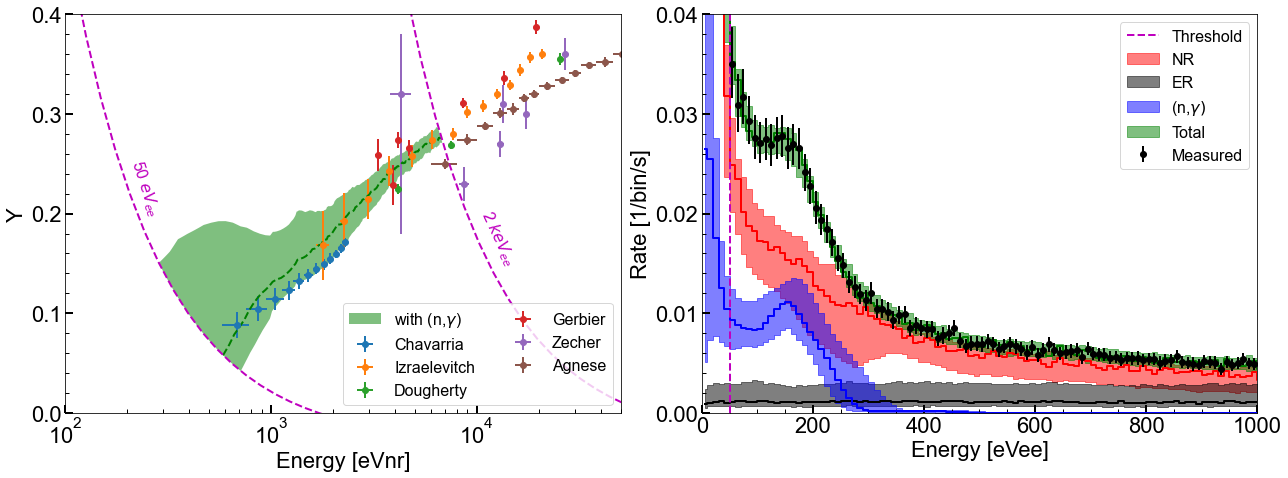

In [115]:
fig_w=9
fig,axs=subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))

iPlot=1

if iPlot==0:
    cut=cut_noNG
else:
    cut=cut_wNG

labels=[r'no (n,$\gamma$)',r'with (n,$\gamma$)']
colors=['gray','green']

#Add other measurements from lit
pt.plotOldYs(axs[0],datasets=['chav','izr','dough','gerb','zech','agnese'],
             labels=['Chavarria','Izraelevitch','Dougherty','Gerbier','Zecher','Agnese'],
             fmt='o',markersize=6)

axs[0].fill(*EYenvelopes[iPlot],colors[iPlot],alpha=0.5,label=labels[iPlot])

axs[0].plot(scanData['lE_nrs'][iBest[iPlot]][Ebin_ctr>50],scanData['lYs'][iBest[iPlot]][Ebin_ctr>50], colors[iPlot],linestyle='--')

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],R_meas[Ebin_ctr>50],(dR_meas.T[Ebin_ctr>50]).T,
                ecolor='k', marker='o',markersize=6,color='k', linestyle='none',label='Measured',zorder=5)

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['NR']['min'],color='r',where='mid')
axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['ER']['min'],color='k',where='mid')
axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['NG']['min'],color='b',where='mid')
axs[1].step(ERmidData[iPlot]['eVee'],ERmidData[iPlot]['Total']['min'],color='g',where='mid')

axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['NR']['min'],ERenvData[iPlot]['NR']['max'],color='r',alpha=0.5,step='mid',label='NR')
axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['ER']['min'],ERenvData[iPlot]['ER']['max'],color='k',alpha=0.5,step='mid',label='ER')
axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['NG']['min'],ERenvData[iPlot]['NG']['max'],color='b',alpha=0.5,step='mid',label=r'(n,$\gamma)$')
axs[1].fill_between(ERenvData[iPlot]['eVee'],ERenvData[iPlot]['Total']['min'],ERenvData[iPlot]['Total']['max'],color='g',alpha=0.5,step='mid',label='Total')


#Analysis Range
axs[1].axvline(50,linestyle='--',color='m',label='Threshold')

Yiso = lambda Enr,Eee: Eee/Enr*(1+eps/V)-eps/V
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),50),'--m')
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),2e3),'--m')

axs[0].text(2e2,0.2,r'50 $eV_{ee}$',size=16,color='m',rotation=-72)
axs[0].text(1e4,0.15,r'2 $keV_{ee}$',size=16,color='m',rotation=-65)

#Axes
axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[0].set_xlabel('Energy [eVnr]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2,prop={'size': 16})

axs[1].set_ylim(0,0.04)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs[1].set_xlim(0,1e3)

axs[1].set_xlabel('Energy [eVee]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right', prop={'size': 16})

tight_layout()